# Primer to Support Vector Machines

### By Dr. Jonne Pohjankukka

 This tutorial is an ongoing self-made project based on my exercise work on mathematical optimization in 2015. The project is yet unfinished and not in a fully readable state. The upcoming versions will include: 

 updates in the text, fixing of typos, references, added code etc. 
 
 **STATUS OF TUTORIAL**: I'm currently editing section 5 so sections 1-4 are (or should be) in a readable state. The code at the bottom is working at the moment, of course cleaning, commenting etc. needs to be done. The tutorial is I'd say 70% ready.  

1. [Machine learning](#1.)<br>
2. [Linear vs. nonlinear models](#2.)<br>
3. [Support vector machines](#3.)<br>
    3.1 [How to find the maximum margin model?](#3.1)<br>
    3.2 [Is maximum margin model really better?](#3.2)<br>
    3.3 [What if data is not linearly separable?](#3.3)<br>
    3.4 [Kernel methods](#3.4)<br>
4. [Solving the optimal SVM](#4.)<br>
    4.1 [Quadratic programming](#4.1)<br>
    4.2 [Lagrangian dual](#4.2)<br>
    4.3 [The dual of hard margin SVM](#4.3)<br>
    4.4 [Example: solving the SVM classifier via the Lagrangian dual form](#4.4)<br>
    4.5 [The dual in the $\mathcal{Z}$-space](#4.5)<br>
5. [Simple algorithm for solving the SVM model](#5.)<br>
    5.1 [Active set methods](#5.1)<br>
    5.2 [Gradient projection](#5.2)<br>
    5.3 [Constructing a gradient projection/active set-based SVM solver](#5.3)<br>
    5.4 [Pseudocode for the GPAS SVM solver](#5.4)<br>
6. [Appendix: code listing](#Appendix)<br>


#### Preface: to whom is this tutorial for? 
I think it was back in 2014 or 2015 when I first came across with support vector machines and I remember being frustrated for the difficulty of finding good practical tutorials on the subject. I could find many tutorials online describing the theory and general ideas, but everytime after reading them I had one question: okay, now what? What do I type in my IDE? I could understand the idea, but when I needed to do some programming I found out I actually did not understand it that well. So what I did next was to search again online for some advices, and I found out these guides repeating themselves: "use a package", "download and apply a package". I understand that this is a perfectly valid solution if your goal is simply to apply support vector machines. In my case, I wanted to understand **every step going on under the hood**. I wanted to understand how one constructs a support vector machine model, how does one train it et cetera **without using any packages at all** (excluding trivial packages of course such as NumPy). How does one implement the model, the mathematical optimization, kernel tricks, everything by yourself? 

This tutorial is an attempt to provide readers a primer into the subject who have similar problems and frustrations that I had when first running into the subject. I will provide the reader with the general idea of support vector machines, its basic theretical background, practical pen-and-paper examples, pseudocode and Python codes which do not apply any packages related to machines learning or mathematical optimization. I will assume the reader has some understanding on probability, linear algebra and mathematical optimization. Enjoy the ride =) 



<a id='1.'></a>
#### 1. Machine learning
What is machine learning (ML)? ML is a subfield of computer science focused on the research and desing of models, which aim to discover and learn patterns from data. Applications of ML could be for example the prediction of stock price values, classification of soil bearing capacity, or forecasting the effects of drinking milk to the acidity levels in human stomach. ML combines techniques from many fields of science, such as probability theory, statistics, physics, mathematical optimization and neuroscience. 

One of the most important (or maybe better say **the most important**) issues in ML is the concept of generalizability, which measures how well a ML model performs in making predictions in new situations (that is, with new data). A model probably fails to generalize well, if it is "fitted" too much to the data (this claim is also backed up theoretically). The notion of "fitting a model to data", usually means that we minimize some error function, which describes the goodness-of-fit of our model to the data. The lower the error, the better the fit. In fields such as mathmetical optimization or calculus of variation, the goal is many times to find the absolute minimum of this error (say, the optimum trajectory of a particle). It has however been shown, both from a theoretical and practical perspective, that if you train a model too much _overfitting_ will occur. 

Overfitting means that the model has learned not only the intrinsic phenomena in the data, but also an additional non-existing relationship called _noise_, which can not be learned by definition. Noise is present in all data you ever measure and can be caused e.g. by measurement errors, weather or malfunctioning sensors. Thus by overfitting a model, we have learned an incorrent relationship from the data, and are more likely to generalize worse. A common way to tackel overfitting is to apply a method known as _regularization_, which basically means restricting the learning process by preventing it from learning too complicated functions. There are many ways to tackle overfitting such as using penalty term or early-stopping methods, but we will not go deeper into this subject in this tutorial. Readers interested with overfitting can find more information from standard ML literature. 

<a id='2.'></a>
#### 2. Linear vs. nonlinear models
All methods of ML can be divided into two groups: linear or nonlinear. Linear models are simple and effective methods in many applications describing real world phenomena, but sometimes their expressive power is not enough to learn more complicated relationships in the data. In cases like this, nonlinear methods are usually applied due to their higher expressive power. However, due to its simplicity a linear model is less likely to overfit than nonlinear model. Also in general, nonlinear models require more data than linear models to achieve succesful generalization. There is therefore a trade-off between the expressive power of a model and its likelihood of overfitting to the data. Because of the higher expressive power, nonlinear models are more easily fitted to the noise in the data. With this in mind, it begs now the question: does there exist a model which contains both the resistance towards noise (as in linear models) and high expressive power (as in nonlinear models). A clever method called _support vector machines_ (SVM) was proposed for achieving this by Vladimir Vapnik and Alexey Chervonenkis in 1963, which we will discuss next. In what follows, we will go through the motivation, theory, examples and a self-made implementation (in pseudo- and Python code) of the SVM method.   

<a id='3.'></a>
#### 3. Support vector machines
We will begin with a simple geometric illustration, which best explains the intuition behind SVM. In figure 1 is presented data from two different classes denoted by blue crosses and red circles. The lines depict three competing decision lines which we use to determine the classification regions. The data is _linearly separable_ which means that the data can be divided into two distinct subspaces by the line (or a hyperplane in higher dimensions). Which of these three lines would the best choice and why? Or would you say they are all equally good? After all, all the lines perfectly classify the data. I'm betting however, that you would probably select the line in the rightmost image. Why would we choose this line? What is the intuition behind our choice? Remember that all data we ever measure contains noise. It would be good therefore to select such a decision line which would be most robust against this noise. You can think of the effect of noise in the four data points by shifting them randomly into arbitrary directions a tiny bit. We would want the decision line to allow as much of this random shifting (due to noise) as possible and still achieve correct classification. You would agree that decision line in the rightmost image allows the largest amount of random shifting in the points in the image, right? 

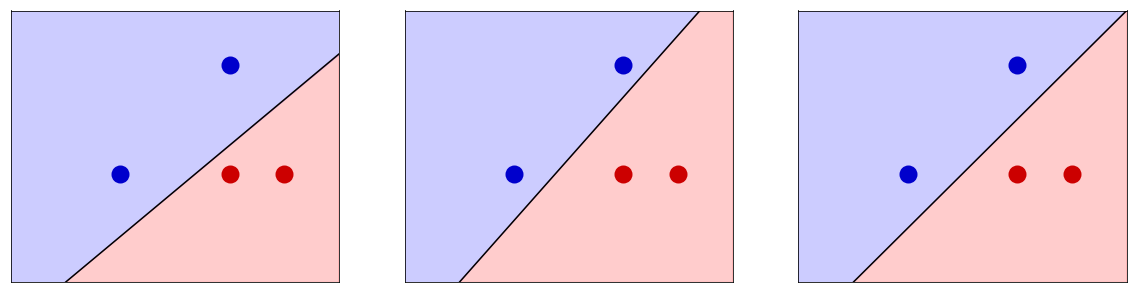

In [23]:
# Make Figure 1 plot
drawClassifierLines(showRadius=False)

<center>Figure 1: Geometric intuition behind the SVM.</center>

As we discussed, we would like to select a decision line which allows as much as possible this random shifting in the data (i.e. noise) without affecting the classification. We can picture this random shifting caused by noise in terms of circles or spheres with radius $r$ around the data points (see figure 2). Notice that in the rightmost image the circles have the largest radius, and so we can think that the data points are allowed to move within this circle (i.e. we have uncertainty) and still we get correct classification. What we would like to do, is to select a linear classifier which maximizes the radius of these spheres. In this way, we have maximized the model's robustness against noise in the data. Notice that in the rightmost image, the distance from the line to the closest data points is maximized. The data points at which the spheres first touch the decision line are called _support vectors_, from which the name of the SVM comes from. The support vectors play a special role in the SVM since they are solely responsible in determining the classifier line. If we would for example remove the rightmost data point from the below images, it would not affect the choice of the classifier line, only the support vectors have impact on this. Lastly, since in SVM the point is to maximize the distance of the line to the support vectors (called the _margin_), SVMs are also called _maximum margin models_.       

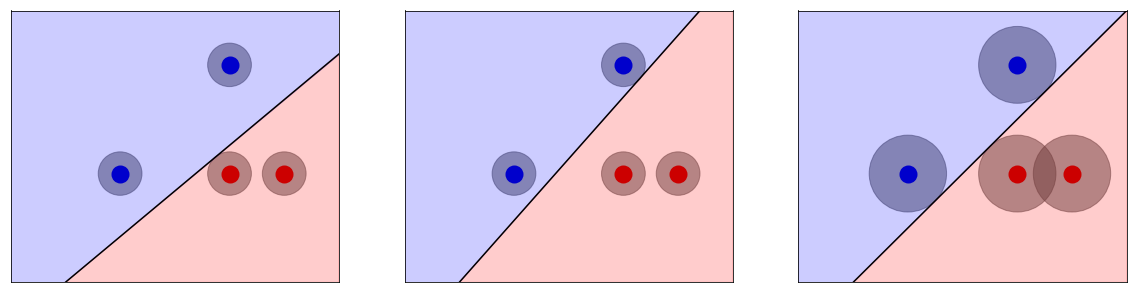

In [24]:
# Make Figure 2 plot
drawClassifierLines(showRadius=True)

<center>Figure 2: Uncertainties around the data points in figure 1 illustrated.</center>

<a id='3.1'></a>
#### 3.1 How to find the maximum margin model? 
Lets now proceed to formalize the concepts of the SVM and find out how can we solve the maximum margin hyperplane. Denote by $\textbf{x}\in\mathcal{X}\subset\mathbb{R}^d$ an input vector, $\textbf{w}\in\mathbb{R}^d$ as hyperplane weight values, $y\in\{-1, 1\}$ as label value and $b\in\mathbb{R}$ as a constant intercept term. A hyperplane $h$ defined by vector $\textbf{w}$ and constant $b$ separates the data points $(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n)$ if and only if: 

$$y_i(\textbf{w}^T\textbf{x}_i+b) > 0\;\;\;(i = 1, 2, ..., n),\;\;\;\;\;\;\;\;\;\;\;\;(1)$$

where $h(\textbf{x}) = \textbf{w}^T\textbf{x}+b$ is called the _signal_ of input $\textbf{x}$. That is, for data points having $y=-1$ we want the hyperplane to have a negative signal $h(\textbf{x}) <0$ and for data points with $y=1$ we want $h(\textbf{x}) >0$ correspondingly. Notice next that the equations in $(1)$ are always satisfied also for any $h(\textbf{x})/\rho$, where $\rho > 0$. Define next (for reasons later coming clear):

$$\rho := \underset{i = 1, 2, ..., n}{\text{min}} y_i(\textbf{w}^T\textbf{x}_i+b),$$

and redefine the separating hyperplane as $h(\textbf{x})/\rho$. For this redefined hyperplane we have: 

$$\underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\frac{h(\textbf{x})}{\rho}\right)=\underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\frac{\textbf{w}^T\textbf{x}_i}{\rho}+\frac{b}{\rho}\right)=\frac{1}{\rho}\underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\textbf{w}^T\textbf{x}_i+b\right)=\frac{\rho}{\rho}=1,$$

that is, the hyperplane separates all the data points if and only if: 

$$\underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\textbf{w}^T\textbf{x}_i+b\right)=1.\;\;\;\;\;\;\;\;\;\;\;\;(2)$$

So we have now learned that a hyperplane $h$ separates the data points only if the condition in $(2)$ is met. This condition is not yet though sufficient enough to define the problem of finding a maximum margin hyperplane. Recall that one of the defining factors of the SVM was also the fact that the margin (distance to the closest, a.k.a support vectors) needs to maximized. In other words, we want to maximize the distance between the hyperplane $h$ and the vector $\textbf{x}$ closest to it. 

To start, lets first figure out how one generally calculates the distance between a hyperplane and a vector point. To solve this distance we need to calculate the perpendicular distance between $h$ and $\textbf{x}$. Let $\textbf{u}$ be a unit vector perpendicular to $h$ and $\textbf{x}'$ some point on $h$, i.e. $h(\textbf{x}') = \textbf{w}^T\textbf{x}' + b = 0$. Then, from basic linear algebra (make e.g. a Google search) we know that the distance between $h$ and point $\textbf{x}$ is the projection $d(h, \textbf{x}) = |\textbf{u}^T(\textbf{x}-\textbf{x}')|$. Note that $\textbf{w}$ is perpendicular to the plane $h$, since for two points $\textbf{x}', \textbf{x}''$ on the plane $h$ we have:

$$\textbf{w}^T(\textbf{x}''-\textbf{x}') = \textbf{w}^T\textbf{x}''-\textbf{w}^T\textbf{x}'=-b+b = 0,$$

that is $\textbf{w}$ is perpendicular to any vector $\textbf{x}''-\textbf{x}'$ on $h$. We can now set $\textbf{u} = \textbf{w}/||\textbf{w}||$, where $||\textbf{w}||$ is the magnitude of vector $\textbf{w}$. Hence, we get the distance from an arbitrary point $\textbf{x}$ to plane $h$ as: 

$$d(h, \textbf{x}) = \frac{\left\lvert\textbf{w}^T(\textbf{x}-\textbf{x}')\right\rvert}{||\textbf{w}||}= \frac{\left\lvert\textbf{w}^T\textbf{x}-\textbf{w}^T\textbf{x}'\right\rvert}{||\textbf{w}||} = \frac{\left\lvert\textbf{w}^T\textbf{x}+b\right\rvert}{||\textbf{w}||}.$$

Furthermore, since for a binary SVM classifier we have $y_i\in \{-1, 1\} \forall i$, we get: 

$$\left\lvert\textbf{w}^T\textbf{x}_i+b\right\rvert = y_i(\textbf{w}^T\textbf{x}_i+b)\;\forall i,$$

and because of $(2)$ we have that:

$$\underset{i = 1, 2, ..., n}{\text{min}} d(h, \textbf{x}_i) = \underset{i = 1, 2, ..., n}{\text{min}} \frac{y_i(\textbf{w}^T\textbf{x}_i+b)}{||\textbf{w}||}= \frac{1}{||\textbf{w}||}\underset{i = 1, 2, ..., n}{\text{min}} y_i(\textbf{w}^T\textbf{x}_i+b) = \frac{1}{||\textbf{w}||}.\;\;\;\;\;\;\;\;\;\;\;\;(3)$$

The nice and simple form of equation $(3)$ is the reason why we redefined the hyperplane $h$ earlier by scaling it with the constant $\rho$, giving us thus a nice numerator of 1. We have now found all the ingredients we need to define the problem of solving the maximum margin model: A SVM model (binary classification) is such a hyperplane, which maximizes the value of $1/||\textbf{w}||$ (margin) and satisfies the condition in equation $(2)$. This can expressed in the following optimization problem: 

\begin{alignat}{2}
&\underset{\textbf{w}, b}{\text{minimize:}}        &\qquad& \frac{1}{2}\textbf{w}^T\textbf{w} \\
&\text{subject to:} &      & \underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\textbf{w}^T\textbf{x}_i+b\right)=1.
\;\;\;\;\;\;\;\;\;\;\;\;(4)
\end{alignat}

From the perspective of mathematical optimization, it is easier to solve the problem:

\begin{alignat}{2}
&\underset{\textbf{w}, b}{\text{minimize:}}        &\qquad& \frac{1}{2}\textbf{w}^T\textbf{w} \\
&\text{subject to:} &      & y_i\left(\textbf{w}^T\textbf{x}_i+b\right)\geq 1,\;\;\;(i=1,2, ..., n)
\;\;\;\;\;\;\;\;\;\;\;\;(5)
\end{alignat}

which is equivalent to problem $(4)$ at the optimal solution, given that the data set contains samples with negative and positive labels. To show that equations $(4)$ and $(5)$ are equivalent at the optimum, suppose the solution $(\textbf{w}^*, b^*)$ of equation $(5)$ has: 

$$\rho^* = \underset{i = 1, 2, ..., n}{\text{min}} y_i\left(\textbf{w}^{*T}\textbf{x}_i+b^*\right) > 1,$$

which means that $(\textbf{w}^*, b^*)$ is not a solution to equation $(4)$. Consider now a hyperplane $(\textbf{w}, b) = \frac{1}{\rho^*}(\textbf{w}^*, b^*)$ which satisfies the constraints in equation $(5)$. But now we have that $||\textbf{w}|| = \frac{1}{\rho^*}||\textbf{w}^*|| < ||\textbf{w}^*||$, which means that $\textbf{w}^*$ can not be optimal for equation $(5)$ unless $\textbf{w}^*=\textbf{0}$. This however is not possible, because the hyperplane $(\textbf{0}, b)$ can not correctly classify the negative and positive data samples $\blacksquare$. So, once we have solved the optimal solution $(\textbf{w}^*, b^*)$ to equation $(5)$, we get the maximum margin classifier model (a.k.a SVM) as: 

$$g(\textbf{x})=\text{sign}\left(\textbf{w}^{*T}\textbf{x}+b^*\right)\in\{-1, 1\}.\;\;\;\;\;\;\;\;\;\;\;\;(6)$$

In the upcoming sections, we will see how to solve the optimization problem of equation $(5)$. First however, we will have a short discussion on why the maximum margin model is better than a non-maximum margin model in terms of generalizability. 

<a id='3.2'></a>
#### 3.2 Is maximum margin model really better?
In earlier sections, we had the intuition that a linear classifier with a larger margin would probably perform better than one with a smaller margin. In fact, our intuition is justified also mathematically by a special number called the _Vapnik-Chervonenkis-dimension_ $d_{\text{VC}}\in \mathbb{N}_{>0}$ (VC-dimension), which quantifies a probabilistic bound for the classification error of the SVM model. Generally speaking, a model with a smaller VC-dimension is more likely to achieve succesful generalization than one with a higher VC-dimension. And it is indeed the case (see the works of e.g. V. Vapnik), that the VC-dimension of a SVM model is smaller than the VC-dimension of an unrestricted linear classifier (unrestricted by the margin that is). This fact is a result from an inequality called the _VC-inequality_ (related closely to the Hoeffding inequality), which states that: 

$$P\left[\underset{h\in\mathcal{H}}{\text{sup}}\left\lvert E_{\text{in}}(h)-E_{\text{out}}(h)\right\rvert > \varepsilon \right] \leq 4m_{\mathcal{H}}(2n)\exp\left(-\frac{1}{8}\varepsilon^2 n\right),\;\;\;\;\;\;\;\;\;\;\;\;(7)$$

where $\mathcal{H}$ is the hypothesis set, that is, a set of functions from which we are searching for the model $h$, $\varepsilon >0$ is an error bound and $n\in\mathbb{N}_{>0}$ is the number of data points. The functions $E_{\text{in}}(h), E_{\text{out}}(h): \mathcal{H}\to \mathbb{R}$ denote the training and generalization errors of hypothesis $h$. That is, $E_{\text{in}}(h)$ describes how well we were able to fit model $h$ to the observed data $\mathcal{D}=\{(\textbf{x}_1, y_1), (\textbf{x}_2, y_2), ..., (\textbf{x}_n, y_n)\}$, and $E_{\text{out}}(h)$ describes how well the model $h$ performs with new yet unseen data. Our goal is to have $E_{\text{in}}(h)\approx E_{\text{out}}(h)$, because in this case the we can trust that our model's performance estimated with the data set $\mathcal{D}$ reflects its performance in a general situation. 

The function $m_{\mathcal{H}}(2n):\mathbb{N}_{>0}\to \mathbb{N}$ maps $2n$ to a number, which describes the maximum number of dichotomies that can be generated by the hypothesis set $\mathcal{H}$ on any $2n$ data points. In other words, it gives a quantifying number on how many ways the hypothesis set $\mathcal{H}$ can split $2n$ data points into two categories. If $m_{\mathcal{H}}(c) = 2^{c}$ for $c$ data points, then we say that the hypothesis set $\mathcal{H}$ is able _shatter_ the $c$ data points, that is find all possible dichotomies (classifications) for the data. To put the relationship between $d_{\text{VC}}$ and $m_{\mathcal{H}}(c)$ explicit, the VC-dimension is defined as $d_{\text{VC}}\equiv \max\{c\in\mathbb{N}\,|\,m_\mathcal{H}(c)=2^c\}$. In other words, VC-dimension is the maximum number of data points the hypothesis set $\mathcal{H}$ is able to shatter. The next question now is, what has the VC-dimension got to do with the VC-inequality? It is known, that if a hypothesis set $\mathcal{H}$ has a finite $d_{\text{VC}}$, then it holds that: 

$$m_{\mathcal{H}}(2n) \leq \sum_{i=0}^{d_{\text{VC}}} {{2n}\choose i},$$

and therefore a hypothesis set with a smaller VC-dimension has a smaller multiplying factor in the right side of equation $(7)$ resulting in a smaller probability bound. This is also somewhat intuitive if you think about. If you are using a hypothesis set with unrestricted (by the margin) classifier models, then you would probably be able to find more dichotomies for the data set $\mathcal{D}$, than with the hypothesis set consisting from models with the restriction to maximize the margin. With a large number of equally good hypotheses to choose from, you would have smaller chances (a higher probability bound in the VC-inequality) to pick the right one unless you are very lucky.    

<a id='3.3'></a>
#### 3.3 What if data is not linearly separable?
So far, we have been talking about cases where the data set can be separated by a linear model. In many practical situations however the data set can not be separated by a linear model. In Figure 3 I have illustrated two examples of data sets which can not be separated by a linear model.

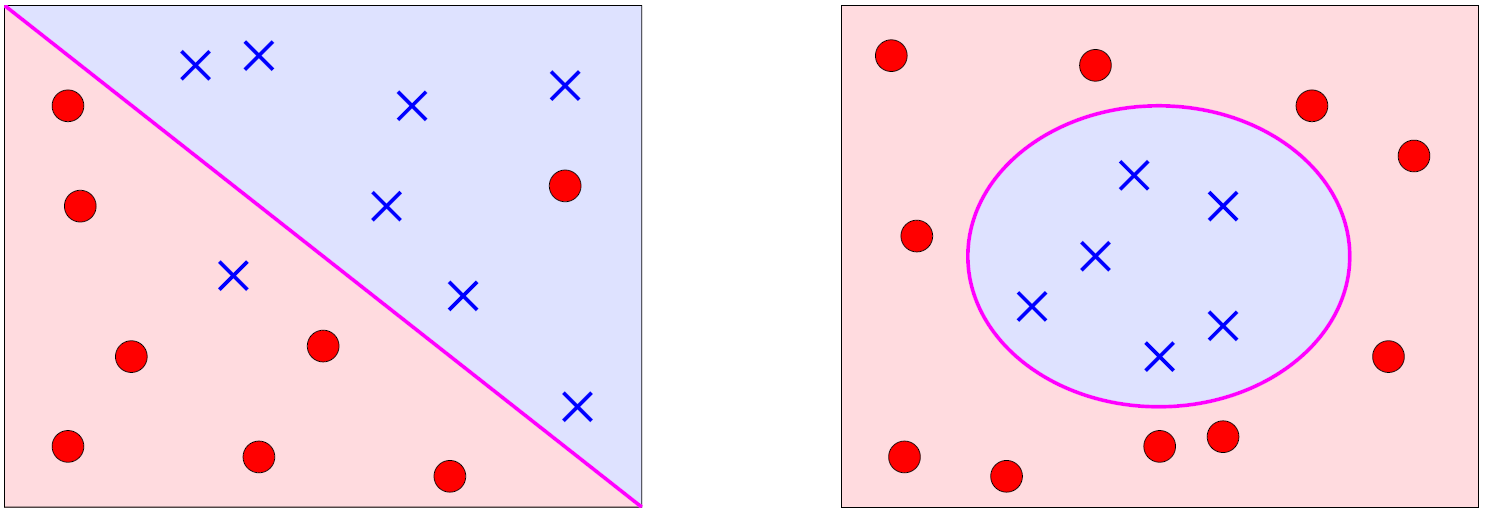
<center>Figure 3: Data which is not linearly separable.</center>

So how should we proceed from this? Well, fortunately we two options two consider. Firstly, we can loosen up the condition on the SVM which requires all the data points to be classified correctly. We do this by allowing few misclassifications for the model to occur. An SVM with a looser condition like this is called the _soft margin SVM_, which does not force a perfect classification and allows some mistakes to occur. On the left side of figure 3, we see an example of a soft margin SVM model. Our second option to the separability problem, is to first apply a nonlinear transformation to the data making it linearly separable, and then fit a hard margin linear SVM into this transformed data. In the right side of figure 3 is an example of this second approach. Note that the nonlinear model you seen here is a representation of the linear model of the transformed space in the original data space. The nonlinear transformation is achieved by a function $\Phi:\mathcal{X} \to \mathcal{Z}\subset \mathbb{R}^q$, which transforms the input vectors into $\textbf{z}_i = \Phi(\textbf{x}_i)$. After the transformation, the optimization problem in equation $(5)$ becomes: 

\begin{alignat}{2}
&\underset{\textbf{w}, b}{\text{minimize:}}        &\qquad& \frac{1}{2}\textbf{w}^T\textbf{w} \\
&\text{subject to:} &      & y_i\left(\textbf{w}^T\textbf{z}_i+b\right)\geq 1,\;\;\;(i=1,2, ..., n),
\;\;\;\;\;\;\;\;\;\;\;\;(8)
\end{alignat}

and similarly to equation $(6)$ we get the nonlinear hard margin SVM model as:

$$g(\textbf{x})=\text{sign}\left(\textbf{w}^{*T}\Phi(\textbf{x})+b^*\right)\in\{-1, 1\}.\;\;\;\;\;\;\;\;\;\;\;\;(9)$$

What happens to the generalization capability if we use nonlinear transformation for the data? Does it get worse? In general, the price we pay for using nonlinear models with higher expressive power is that we have a larger risk to overfit the data and that the probability of successful generalization decreases. Fortunately, a neat mathematical theorem exists (see e.g. Mostafa et al. for proofs) which helps us tackle the generalization problem of SVMs using nonlinear transformation. The theorem states that: 

**Theorem:** the VC-dimension of maximum margin classifier SVM with bounded input data $||\textbf{x}||\leq R$ and margin $r\in \mathbb{R}^{+}$ follows the inequality:

$$d_{\text{VC}} \leq \lceil R^2 / r^2 \rceil +1,$$

regardless on the nonlinear transformation $\Phi$. This means that even if SVM incorporates an infinite dimensional transformation, generalization is achieved as long as we use large enough margin $r$.

<a id='3.4'></a>
#### 3.4 Kernel methods
In earlier sections, we went through formulating the mathematical optimization problem of solving a SVM model. This problem was presented explicitly in equations $(5)$ and $(8)$. It will in later sections become clear that when solving these problems, we need to calculate inner products $\textbf{x}_i^T\textbf{x}_j$ (linear SVM) and $\textbf{z}_i^T\textbf{z}_j=\Phi(\textbf{x}_i)^T\Phi(\textbf{x}_j)$ (nonlinear SVM). This seems simple enough, as it is in many cases but one can find transformations $\Phi$ which map the inputs $\textbf{x}$ into infinite dimensional vectors (i.e. $d=\infty$). It is obvious, that we can not calculate the inner products of infinite dimensional vectors $\textbf{z}$, since this would require us first to explicitly calculate the infinite vectors $\textbf{z}$. Fortunately though, there exists cool functions which allow us to calculate these infinite inner products without explicitly knowing the vectors $\textbf{z}$. These functions are called _kernel functions_, which describe the inner products of vectors in some (possibly infinite dimensional) space $\mathcal{Z}$. To be explicit, the kernel functions defined by transformation $\Phi$ are defined as: 

$$K_{\Phi}(\textbf{x}, \textbf{x}')\equiv \Phi(\textbf{x})^T\Phi(\textbf{x}').$$

In other words, kernel function $K_{\Phi}$ takes two vectors $\textbf{x}, \textbf{x}' \in \mathcal{X}$ as input and returns the inner product of $\Phi$-transformed vectors in $\mathcal{Z}$-space. This process is called the _kernel trick_, where the trick part comes from the fact that we do not need to explicitly calculate the vectors in $\mathcal{Z}$-space in order to calculate their inner product. To give few examples of common kernel functions, a first example is the _polynomial kernel function_ of $Q$-degree defined as: 

$$K(\textbf{x}, \textbf{x}') \equiv (\lambda + \gamma\textbf{x}^T\textbf{x}')^Q,\;\;\;\;\;\;\;\;\;\;\;\;(10)$$

where $\lambda, \gamma > 0$. Another  common example is the _Gaussian radial basis function kernel_ defined as: 

$$K(\textbf{x}, \textbf{x}') \equiv \exp\left(-\frac{||\textbf{x}-\textbf{x}'||^2}{2\sigma^2}\right),\;\;\;\;\;\;\;\;\;\;\;\;(11)$$

where $\sigma > 0$. It is straightforward to show, that if we set $\sigma = 1$ in equation $(11)$, then we have

$$K(\textbf{x}, \textbf{x}') = \exp\left(-\frac12||\textbf{x}-\textbf{x}'||^2\right) = \sum_{k=0}^{\infty} \frac{(\textbf{x}^T\textbf{x}')^k}{k!}\exp\left(-\frac{1}{2}||\textbf{x}||^2\right)\exp\left(-\frac{1}{2}||\textbf{x}'||^2\right),$$

which represents an inner product in an _infinite dimensional_ $\mathcal{Z}$-space (the $\Phi$-function produces an infinite dimensional vector). It turns out also, that one can construct his own kernel functions $K$, if it is valid that the symmetric matrix: 

$$K_{M}=\begin{bmatrix}
    K(\textbf{x}_1, \textbf{x}_1) & K(\textbf{x}_1, \textbf{x}_2) & \cdots &  K(\textbf{x}_1, \textbf{x}_n) \\
    K(\textbf{x}_2, \textbf{x}_1) & K(\textbf{x}_2, \textbf{x}_2) & \cdots &  K(\textbf{x}_2, \textbf{x}_n) \\
    \vdots & \vdots & \ddots & \vdots \\
    K(\textbf{x}_n, \textbf{x}_1) & K(\textbf{x}_n, \textbf{x}_2) & \cdots &  K(\textbf{x}_n, \textbf{x}_n) 
\end{bmatrix}, \;\;\;\;\;\;\;\;\;\;\;\;(12)$$

is positive semidefinite (i.e. $\textbf{x}_i^TK_{M}\textbf{x}_i \geq 0\; \forall\; i$) for all vectors $\{\textbf{x}_1, \textbf{x}_2, ..., \textbf{x}_n\}$. This condition is called _Mercer's condition_. In other words, if your $K$ satisfies Mercer's condition, then you have a valid kernel function.  

<a id='4.'></a>
#### 4. Solving the optimal SVM
We have so far gone through the core ideas of SVM models: the maximum margin classifier, VC-inequality, linearly/non-linearly separable data and the kernel methods. We have observed, that in order to solve the SVM classifier $(\textbf{w}, b)$ we need to solve the problem in equation $(5)$:

\begin{alignat}{2}
&\underset{\textbf{w}, b}{\text{minimize:}}        &\qquad& \frac{1}{2}\textbf{w}^T\textbf{w} \\
&\text{subject to:} &      & y_i\left(\textbf{w}^T\textbf{x}_i+b\right)\geq 1\;\;\;(i=1,2, ..., n).
\end{alignat}

Lets now go on and solve this problem in a toy example. Let the input data be defined in the following way:

$$X = \begin{bmatrix}
    0 & 0 \\
    2 & 2 \\
    2 & 0 \\
    3 & 0 
\end{bmatrix}\;\;\;\textbf{y} = \begin{bmatrix}
    -1 \\ -1 \\ +1 \\ +1 
\end{bmatrix},$$

where matrix $X$ represents the container of input vectors of $\textbf{x}$ and $\textbf{y}$ represents the class labels correspondingly. Each row in $X$ and $\textbf{y}$ correspond to a single data point. Formulating the problem of equation $(5)$ in terms of this data we get: 

\begin{equation*}
\begin{aligned}
& \underset{w_1, w_2, b}{\text{minimize:}}
& & \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \frac{1}{2}(w_1^2+w_2^2) \\
& \text{subject to:}
& &  \begin{aligned}[c]
-b & \geq 1\;\;(\text{i})\\
-(2w_1+2w_2+b) & \geq 1 \;\; (\text{ii})\\
2w_1+b & \geq 1 \;\; (\text{iii})\\
3w_1+b & \geq 1 \;\; (\text{iv}).
\end{aligned}
\end{aligned}
\end{equation*}

By combining inequalities (i), (iii) and (ii), (iii) together we get the conditions $w_1 \geq 1$ and $w_2 \leq -1$. By now squaring both these two new conditions and combining them we get the condition $\frac{1}{2}(w_1^2+w_2^2)\geq 1$. From this we see that the minimum is achieved when (with conditions satisfied) $w_1 = 1$ ja $w_2 = -1$. Substituting these values of $w_1, w_2$ into inequalities (ii)-(iv) we get that $b=-1$ and so the SVM model in this case is: 

$$(w_1^*, w_2^*, b^*) = (1, -1, -1),$$  

and so in terms of equation $(6)$ we get the SVM classifier as:  

\begin{equation*}
g(\textbf{x}) = \text{sign}\left(x_1 - x_2 -1 \right).
\end{equation*}

Notice that the width of the margin in this case is $\frac{1}{||\textbf{w}^*||}=\frac{1}{\sqrt{2}}\approx 0.707$. This is illustrated in figure X, with the distance from the line to the support vectors is $\frac{1}{\sqrt{2}}$. It was fairly easy to solve this particular SVM model but in general it is not this easy. The problem might have a lot more parameters and inequalities in which case we need to use more sophisticated methods to solve the SVM model. We will next consider _quadratic programming_, which we use for solving more general SVM models. 

<a id='4.1'></a>
#### 4.1 Quadratic programming
In this section we will aim to solve the parameters $(\textbf{w}, b)$ of the SVM model in equation $(6)$ using the methods of quadratic programming (QP). In a general QP-problem, we aim to solve problem:    

\begin{equation}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} \\
& \text{subject to:}
& &  \; \textbf{a}_i^T\textbf{u} \geq c_i\;\;\;\;\;\left(i = 1, ..., m\right),\;\;\;\;\;\;\;\;\;\;\;\;(13)
\end{aligned}
\end{equation}

where $Q$ is a $l\times l$ symmetric positive semidefinite matrix, $\textbf{u}, \textbf{p}, \textbf{a}_i$ are $l$-dimensional vectors and $c_i$ is some constant. The optimization problem in $(13)$ contains a qudratic term $\frac{1}{2}\textbf{u}^T Q\textbf{u}$ and a linear term $\textbf{p}^T\textbf{u}$. The constraints $\textbf{a}_i^T\textbf{u}\geq c_i$ are linear. Because $Q$ is positive semidefinite the problem in $(13)$ is a convex optimization problem. If the vectors $\textbf{a}_i$ and constants $c_i$ are grouped into matrix $A$ and vector $\textbf{c}$:

\begin{equation*}
A = \left[\begin{array}{c}
\textbf{a}_1^T  \\
\vdots   \\
\textbf{a}_m^T
\end{array}\right]\;\;\;
\textbf{c} = \left[\begin{array}{c}
c_1 \\
\vdots \\
c_m
\end{array}\right],
\end{equation*}

then the optimization problem $(13)$ can be presented in the form:

\begin{equation}
\label{quadprog2}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^T Q\textbf{u} + \textbf{p}^T\textbf{u} \\
& \text{subject to:}
& &  \; A\textbf{u} \geq \textbf{c}.
\end{aligned}
\end{equation}

The constraints of problem $(13)$ can also be presented in the form $A\textbf{u}\leq \textbf{c}$ by multiplying both sides with $-1$. Next we will show that the SVM optimization problem in $(5)$ can be represented as a QP-problem. In order to do this, we must identify $A, Q, \textbf{u}, \textbf{p}$ ja $\textbf{c}$ from problem $(5)$. This requires finding the optimal values of $(\textbf{w}, b)$ so we have now: 

\begin{equation*}
\textbf{u} = \left[ \begin{array}{c}
b\\
\textbf{w}
\end{array} \right] \in \mathbb{R}^{d+1},
\end{equation*}

so $l=d+1$. Our task is to minimize the term $\frac{1}{2}\textbf{w}^T\textbf{w}$, which must be presented in the form $\frac{1}{2}\textbf{u}^T Q\textbf{u} + \textbf{p}^T\textbf{u}$. We note that:  

\begin{equation*}
\textbf{w}^T\textbf{w} = \left[b \;\;\textbf{w}^T \right]\left[\begin{array}{cc}
0 & \textbf{0}_d^T\\
\textbf{0}_d & \textbf{I}_d
\end{array}\right]
\left[ \begin{array}{c}
b\\
\textbf{w}
\end{array} \right],
\end{equation*}

where $\textbf{I}_d$ is a $d\times d$ identity matrix and $\textbf{0}_d$ is a $d$-dimensional zero vector. From this we see that:

\begin{equation*}
Q = \left[\begin{array}{cc}
0 & \textbf{0}_d^T\\
\textbf{0}_d & \textbf{I}_d
\end{array}\right] \;\;\;\;\;\;
\textbf{p} = \textbf{0}_{d+1},
\end{equation*}

where $Q$ is positive semidefinite. Because there are total of $n$ $y_i\left(\textbf{w}^T\textbf{x}_i+b\right) \geq 1$ inequalities we get that $m=n$. Also note that these inequalities are equivalent with the inequalities:

\begin{equation*}
\left[y_i \;\; y_i\textbf{x}_i^T\right]\textbf{u} \geq 1,
\end{equation*}

and so by setting $\textbf{a}_i^T = y_i\left[1 \;\; \textbf{x}_i^T\right]$ and $c_i=1$ in problem $(13)$ we get:

\begin{equation*}
A = \left[\begin{array}{cc}
y_1 & y_1\textbf{x}_1^T \\
\vdots & \vdots \\
y_n & y_n\textbf{x}_n^T
\end{array}\right] \;\;\;\;\;\;
\textbf{c} = \left[\begin{array}{c}
1 \\
\vdots \\
1
\end{array}\right].
\end{equation*}

Therefore we have shown that problem $(5)$ is indeed a QP-problem of form $(13)$. Next, we will take a look at the Lagrangian duality form for hard margin SVM, which makes solving the problem $(13)$ easier and brings in the kernel methods introduced in section 3.4. We will also go through why the problem $(5)$ includes calculating the inner products $\textbf{x}_i^T\textbf{x}_j, \forall i,j \in \{1, ..., n\}$ as we promised earlier in section 3.4.

<a id='4.2'></a>
#### 4.2 Lagrangian dual
In section 3, we discussed about applying the nonlinear transformation $\Phi: \mathcal{X} \to \mathcal{Z} \subset \mathbb{R}^q$ to the input vectors and we ended up into the optimization problem $(8)$. In this problem, we have $q+1$ variables to solve since $\textbf{u} = [\tilde{\textbf{w}}, \tilde{b}] \in \mathbb{R}^{q+1}$. It is quite difficult to solve this problem if $q$ is very large or even infinite $(q=\infty)$. By transforming the problem $(8)$ called the _primal_ into another form called the _Lagrangian dual form_ the SVM problem is transformed into a QP-problem with $n$ variables to be solved with $n+1$ constraints. The dual problem is independent of the dimensionality of the space $\mathcal{Z}$, and depends only from the amount of data points $n$. This is a very useful method to apply especially when $q$ is very large. We will next see how to transform the QP-problem in $(13)$ into a dual form. To begin, we start from the primal form of the problem: 

\begin{equation*}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} \\
& \text{subject to:}
& &  \; \textbf{a}_i^T\textbf{u} \geq c_i\;\;\;\;\;\left(i = 1, ..., m\right).
\end{aligned}
\end{equation*}

We proceed next by dropping out the constraints in the above problem and adding a _penalty term_ in the following way: 

\begin{equation}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} +  \max_{\boldsymbol\alpha \geq \textbf{0}} \sum_{i=1}^m \alpha_i \left( c_i - \textbf{a}_i^T\textbf{u} \right),\;\;\;\;\;\;\;\;\;\;\;\;(14)
\end{aligned}
\end{equation}

where $\boldsymbol\alpha = \left(\alpha_1, ..., \alpha_m\right)$. It can be shown (see e.g. literature on nonlinear programming) that the primal problem $(13)$ is equivalent with this new problem $(14)$, as long as there exists at least one solution which satisfies the constraints of problem $(13)$. The penalty term in $(14)$ encourages the optimization to choose vectors $\textbf{u}$ such that $c_i-\textbf{a}_i^T\textbf{u}\leq 0$ (because $\alpha_i \geq 0$), satisfying thus the constraints in $(13)$. Notice that in $(14)$, at the optimum solution $\left(\textbf{u}^*, \boldsymbol\alpha^*\right)$ we have either $\alpha^*_i = 0$ or $c_i - \textbf{a}_i^T\textbf{u}^*=0\;\forall\,i$. Thus, we can instead of problem $(13)$ solve the simpler unconstrained problem $(14)$. The function in $(14)$ is called the _Lagrangian_ which is defined as: 

\begin{equation}
\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right) = \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} + \sum_{i=1}^m \alpha_i \left( c_i - \textbf{a}_i^T\textbf{u} \right),\;\;\;\;\;\;\;\;\;\;\;\;(15)
\end{equation}

so our task is to solve the optimization task: 

\begin{equation}
\label{LagrangeOpt}
\min_{\textbf{u}\in \mathbb{R}^l}\max_{\boldsymbol\alpha \geq \textbf{0}} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right).\;\;\;\;\;\;\;\;\;\;\;\;(16)
\end{equation}

In convex quadratic programming we can take advantage of the so-called _strong duality_: 

\begin{equation}
\min_{\textbf{u}\in \mathbb{R}^l}\max_{\boldsymbol\alpha \geq \textbf{0}} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right) = \max_{\boldsymbol\alpha \geq \textbf{0}}\min_{\textbf{u}\in \mathbb{R}^l} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right),\;\;\;\;\;\;\;\;\;\;\;\;(17)
\end{equation}

which can be shown to be true if the Lagrangian $\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right)$ has the form as in $(15)$ and there exists a solution satisying the constraints $\textbf{a}_i^T\textbf{u}\geq c_i$. A proof for these facts can be found from literature related to quadratic programming and convex optimization. With the help of the Lagrangian and strong duality we have transformed the original problem $(13)$ into an easier unconstrained optimization problem:   

\begin{equation}
 \max_{\boldsymbol\alpha \geq \textbf{0}}\min_{\textbf{u}\in \mathbb{R}^l} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right),
\end{equation}

which is called the _Lagrangian dual problem_. To wrap up this section, we will state the necessary conditions a solution of the QP-problem in $(13)$ must satisfy.

**Necessary optimality conditions for the QP-problem $(13)$.** If the primal convex QP-problem in $(13)$: 

\begin{equation*}
\begin{aligned}
& \underset{\textbf{u}\in \mathbb{R}^l}{\text{minimize:}}
& & \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} \\
& \text{subject to:}
& &  \; \textbf{a}_i^T\textbf{u} \geq c_i\;\;\;\;\;\left(i = 1, ..., m\right),
\end{aligned}
\end{equation*}

has the corresponding Lagrangian function in $(15)$: 

$$\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right) = \frac{1}{2}\textbf{u}^TQ\textbf{u} + \textbf{p}^T\textbf{u} + \sum_{i=1}^m \alpha_i \left( c_i - \textbf{a}_i^T\textbf{u} \right),$$ 

then the solution $\textbf{u}^*$ is optimal for the primal problem $(13)$, if and only if $\left(\textbf{u}^*, \boldsymbol\alpha^*\right)$ is a solution for the dual problem in $(14)$:

$$ \max_{\boldsymbol\alpha \geq \textbf{0}}\min_{\textbf{u}\in \mathbb{R}^l} \mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right).$$

The optimal solution $\left(\textbf{u}^*, \boldsymbol\alpha^*\right)$ of problem $(14)$ must satisfy the following conditions: 

\begin{equation*}
\begin{aligned}[c]
(\text{i}) & \;\;\;\textbf{a}_i^T\textbf{u}^* \geq c_i\;\;\text{and}\;\;\alpha_i^* \geq 0\;\;\forall\,i.\\[2mm]
(\text{ii}) & \;\;\; \alpha_i^*\left( \textbf{a}_i^T\textbf{u}^* - c_i \right) = 0\;\;\forall\,i.\\[2mm]
(\text{iii}) & \;\;\;\nabla_{\textbf{u}}\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right)|_{\textbf{u}=\textbf{u}^*,\; \boldsymbol\alpha = \boldsymbol\alpha^*} = \textbf{0},
\end{aligned}
\end{equation*}

where $\nabla_{\textbf{u}}$ denotes the gradient with respect to $\textbf{u}$. The conditions (i)-(iii) are called the Karush-K$\ddot{\text{u}}$hn-Tucker (KKT)-conditions. The KKT-conditions give us an analytical way to either check or solve the optimal solution of the QP-problem $(13)$. At the last sections of this tutorial, we will produce an iterative algorithm for solving the SVM model and we therefore do not directly apply the KKT-conditions for solving the optimal SVM model. We can however use the KKT-conditions to check whether our iteratively solved solution is indeed optimal or not.  

<a id='4.3'></a>
#### 4.3 The dual of hard margin SVM
Lets now next get back to solving the SVM model. In section 4.1, we identified the factors $A, Q, \textbf{u}, \textbf{p}, \textbf{c}$ in order to incorporate the SVM problem $(5)$ into the form in $(13)$. We will now proceed to find the Lagrangian dual function $\mathcal{L}\left(\textbf{u}, \boldsymbol\alpha \right)$ of the SVM problem. To recall, our original problem was: 

\begin{equation}
\begin{aligned}
& \underset{b,\textbf{w}}{\text{minimize:}}
& & \frac{1}{2}\textbf{w}^T\textbf{w} \\
& \text{subject to:}
& &  \;y_i\left(\textbf{w}^T\textbf{x}_i+b\right) \geq 1\;\;\;\;\;\;\;(i = 1, ..., n).
\end{aligned}
\end{equation}

The optimal solution we aim to find for this problem is the vector $\textbf{u} = [b, \textbf{w}]^T$. Lets go on and solve the Lagrangian function. Because there are $n$ contraints, we will get $n$ penalty terms into the Lagrangian with coefficients $\alpha_i$. The Lagrangian function is therefore: 

\begin{equation}
\begin{aligned}
\mathcal{L}\left(b, \textbf{w}, \boldsymbol\alpha\right) &= \frac{1}{2}\textbf{w}^T\textbf{w} + \sum_{i=1}^n \alpha_i\left(
1-y_i\left(\textbf{w}^T\textbf{x}_i+b\right)\right)\\
&= \frac{1}{2}\textbf{w}^T\textbf{w} - \sum_{i=1}^n\alpha_iy_i\textbf{w}^T\textbf{x}_i - b\sum_{i=1}^n\alpha_iy_i + \sum_{i=1}^n\alpha_i.\;\;\;\;\;\;\;\;\;\;\;\;(18)
\end{aligned}
\end{equation}

Our first step is to minimize the Lagrangian function with respect to the vector $\textbf{u}$ and then maximize with respect to $\boldsymbol\alpha \geq \textbf{0}$. So lets take the derivative of $\mathcal{L}$ with respect to $b$ and $\textbf{w}$. We get: 

\begin{equation*}
\frac{\partial \mathcal{L}}{\partial b} = -\sum_{i=1}^n\alpha_iy_i \;\;\;\;\;\;\text{and}\;\;\;\;\;\;\frac{\partial \mathcal{L}}{\partial \textbf{w}} = \textbf{w}- \sum_{i=1}^n\alpha_iy_i\textbf{x}_i,
\end{equation*}

and setting these to zero we get: 

\begin{equation}
\sum_{i=1}^n\alpha_iy_i = 0\;\;\;\;\;\;\;\;\;\;\;\;(19)
\end{equation}

\begin{equation}
\textbf{w} = \sum_{i=1}^n\alpha_iy_i\textbf{x}_i.\;\;\;\;\;\;\;\;\;\;\;\;(20)
\end{equation}

By plugging these into the Lagrangian function $\mathcal{L}\left(b, \textbf{w}, \boldsymbol\alpha\right)$ above we get:

\begin{equation}
\begin{aligned}
\mathcal{L}\left(b, \textbf{w}, \boldsymbol\alpha\right) &= \frac{1}{2}\textbf{w}^T\textbf{w} - \sum_{i=1}^n\alpha_iy_i\textbf{w}^T\textbf{x}_i - b\sum_{i=1}^n\alpha_iy_i + \sum_{i=1}^n\alpha_i\\
& = \frac{1}{2}\sum_{i=1}^n\alpha_iy_i\textbf{x}_i^T\sum_{j=1}^n\alpha_jy_j\textbf{x}_j - \sum_{i=1}^n\alpha_iy_i\sum_{j=1}^n\alpha_jy_j\textbf{x}_j^T\textbf{x}_i \\ 
& - b\sum_{i=1}^n\alpha_iy_i + \sum_{i=1}^n\alpha_i
\end{aligned}
\end{equation}

\begin{equation*}
\begin{aligned}
&= \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\textbf{x}_i^T\textbf{x}_j - \sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\textbf{x}_i^T\textbf{x}_j + \sum_{i=1}^n\alpha_i \\
&= -\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\textbf{x}_i^T\textbf{x}_j + \sum_{i=1}^n\alpha_i,
\end{aligned}
\end{equation*}

and so we get that: 

\begin{equation}
\mathcal{L}\left(\boldsymbol\alpha\right) = -\frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\textbf{x}_i^T\textbf{x}_j + \sum_{i=1}^n\alpha_i,
\end{equation}

which is a function of only the vector $\boldsymbol\alpha \geq \textbf{0}$. Thus, in order to solve the SVM model we need to maximize the function $\mathcal{L}\left(\boldsymbol\alpha\right)$ so that $\boldsymbol\alpha \geq \textbf{0}$. Note that we have now new constraints for the variables $\alpha_i$ by the equation $(19)$, from which we get a total of $n+1$ constraints. Instead of maximizing the function $\mathcal{L}\left(\boldsymbol\alpha\right)$ we can also equivalently minimize the function $-\mathcal{L}\left(\boldsymbol\alpha\right)$, and so we have transformed the original optimization problem $(5)$ into the problem:

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
  \;\;\;\;\;\;\;\;\;\; \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j\textbf{x}_i^T\textbf{x}_j - \sum_{i=1}^n\alpha_i \;\;\;\;\;\;\;\;\;\;\;\;(21)\\
& \text{subject to:}
  \;\;\;\;\;\; \sum_{i=1}^n\alpha_iy_i = 0 \\
& \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \alpha_i \geq 0\;\;\;\;\;\;\;(i = 1, ..., n).
\end{aligned}
\end{equation}

From problem $(21)$ we see why the calculation of inner products $\textbf{x}_i^T\textbf{x}_j, \forall \:i, j \in \{1,...,n\}$ is important as we discussed before in section 3.4. The problem $(21)$ can also be rewritten equivalently as the convex QP-problem:

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
& & \frac{1}{2}\boldsymbol\alpha^TQ_D\boldsymbol\alpha -\textbf{1}_n^T\boldsymbol\alpha \\
& \text{subject to:}
& &  \; A_D\boldsymbol\alpha \geq \textbf{0}_{n+2},\;\;\;\;\;\;\;\;\;\;\;\;(22)
\end{aligned}
\end{equation}

where 

\begin{equation*}
Q_D = \left[\begin{array}{ccc}
y_1y_1\textbf{x}_1^T\textbf{x}_1 & \cdots & y_1y_n\textbf{x}_1^T\textbf{x}_n \\
y_2y_1\textbf{x}_2^T\textbf{x}_1 & \cdots & y_2y_n\textbf{x}_2^T\textbf{x}_n \\
\vdots & \vdots & \vdots \\
y_ny_1\textbf{x}_n^T\textbf{x}_1 & \cdots & y_ny_n\textbf{x}_n^T\textbf{x}_n
\end{array}\right]\;\;\;
A_D = \left[\begin{array}{c}
\textbf{y}^T \\
-\textbf{y}^T \\
\textbf{I}_{n\times n}
\end{array}\right]
\end{equation*}

and $\textbf{I}_{n\times n}, \textbf{y}^T, \textbf{0}_{n+2}, \textbf{1}_{n}$ stand for $n\times n$ identity matrix, row vector of labels $\{y_1, y_2, ..., y_n\}$, $(n+2)$-dimensional zero vector and $n$-dimensional vector of ones respectively. It can be shown, that if $Q_D$ is positive semidefinite, then the problem $(21)$ is a convex optimization problem (again, to verify check the literature). When the optimal solution $\boldsymbol\alpha^*$ for this problem has been solved, we get the parameters $(\textbf{w}^*, b^*)$ of the optimal SVM hyperplane as (see equations 2 and 20): 

\begin{equation}
\textbf{w}^* = \sum_{i=1}^ny_i\alpha_i^*\textbf{x}_i\;\;\;\;\;\;\;\;\;\;\;\;(23)
\end{equation}

\begin{equation}
\begin{aligned}
b^* &= \frac{1}{y_s} - \textbf{w}^{*T}\textbf{x}_s\\
&= \frac{1}{y_s} -\sum_{i=1}^ny_i\alpha_i^*\textbf{x}_i^T\textbf{x}_s,\;\;\;\;\;\;\;\;\;\;\;\;(24)
\end{aligned}
\end{equation}

where $\textbf{x}_s$ is any support vector satisfying $\alpha_s^* > 0$. For all non-support vectors it holds that $\alpha_i^* = 0$. Because of the constraint in equation $(2)$, it holds for support vectors $\textbf{x}_s$ that:

$$y_s\left(\textbf{w}^{*T}\textbf{x}_s + b^*\right) = 1.$$ 

The optimal SVM hyperplane model $(\textbf{w}^*, b^*)$ is therefore:

\begin{equation}
\boxed{
\begin{aligned}
g(\textbf{x}) &= \text{sign}\left(\textbf{w}^{*T}\textbf{x} + b^*\right)\\
&= \text{sign}\left(\sum_{i=1}^ny_i\alpha_i^*\textbf{x}_i^T\textbf{x} + b^*\right)\;\;\;\;\;\;\;\;\;\;\;\;(25)\\
&= \text{sign}\left(\sum_{i=1}^ny_i\alpha_i^*\textbf{x}_i^T\left(\textbf{x}-\textbf{x}_s\right) + y_s\right).
\end{aligned}
}
\end{equation}

Also, because only the support vectors $\textbf{x}_s$ affect the selection of the SVM hyperplane $(\alpha_s^* > 0)$ we can write the model in $(25)$ in terms of the support vectors as:

\begin{equation}
\boxed{
g(\textbf{x}) = \text{sign}\left(\sum_{\alpha^*_i > 0} y_i\alpha_i^*\textbf{x}_i^T\textbf{x} + b^*\right).\;\;\;\;\;\;\;\;\;\;\;\;(26)
}
\end{equation}

<a id='4.4'></a>
#### 4.4 Example: solving the SVM classifier via the Lagrangian dual form
Let the observed data in this example be the same as earlier, that is: 

\begin{equation*}
X = \left[\begin{array}{cc}
0 & 0 \\
2 & 2 \\
2 & 0 \\
3 & 0
\end{array}\right]\;\;\;
\textbf{y} = \left[\begin{array}{c}
-1 \\
-1 \\
+1 \\
+1
\end{array}\right].\\[6mm]
\end{equation*}

Here we have that $n=4$. The matrices $Q_D$ and $A_D$ are identified as: 

\begin{equation*}
Q_D = \left[\begin{array}{rrrr}
0 & 0 & 0 & 0 \\
0 & 8 & -4 & -6\\
0 & -4 & 4 & 6\\
0 & -6 & 6 & 9
\end{array}\right]\;\;\;
A_D = \left[\begin{array}{rrrr}
-1 & -1 & 1 & 1 \\
1 & 1 & -1 & -1 \\
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 
\end{array}\right].
\end{equation*}

By taking advantage of $(22)$ we get our optimization problem as minimizing the Lagrangian function: 

\begin{equation*}
\begin{aligned}
& \mathcal{L}\left(\boldsymbol\alpha\right) =
  4\alpha_2^2 + 2\alpha_3^2 + \frac{9}{2}\alpha_4^2 - 4\alpha_2\alpha_3 -6\alpha_2\alpha_4 + 6\alpha_3\alpha_4 -\alpha_1 -\alpha_2-\alpha_3-\alpha_4 \\[2mm]
& \text{subject to:}
  \;\;\;\;\;\; \alpha_1 + \alpha_2 = \alpha_3 + \alpha_4; \\
& \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \alpha_1, \alpha_2, \alpha_3, \alpha_4 \geq 0.
\end{aligned}
\end{equation*}

By plugging the first constraint equation into the Lagrangian function we get: 

$$\mathcal{L}\left(\boldsymbol\alpha\right) =
  4\alpha_2^2 + 2\alpha_3^2 + \frac{9}{2}\alpha_4^2 - 4\alpha_2\alpha_3 -6\alpha_2\alpha_4 + 6\alpha_3\alpha_4 -2\alpha_3-2\alpha_4.$$
  
Now we calculate the partial derivative with respect to parameter $\alpha_2$ and setting this to zero we get:

$$\frac{\partial \mathcal{L}}{\partial \alpha_2} = 8\alpha_2-4\alpha_3-6\alpha_4 = 0\;\;\;\;\leftrightarrow\;\;\;\; \alpha_2 = \frac{1}{2}\alpha_3 + \frac{3}{4}\alpha_4.$$

It then follows that:

$$\alpha_1 = \alpha_3 + \alpha_4 - \alpha_2 = \frac{1}{2}\alpha_3 +\frac{1}{4}\alpha_4.$$

Note also that $\alpha_1, \alpha_2 \geq 0$. By plugging $\alpha_1$ and $\alpha_2$ into the Lagrangian we get: 

$$\mathcal{L}\left(\boldsymbol\alpha\right) = \alpha_3^2+\frac{9}{4}\alpha_4^2+3\alpha_3\alpha_4-2\alpha_3-2\alpha_4.$$

Next we note that:

$$\mathcal{L}\left(\boldsymbol\alpha\right) = \frac{1}{4}\left(2\alpha_3 + 3\alpha_4-2\right)^2+\alpha_4-1,$$

and so taking into account the constraints $\alpha_3, \alpha_4\geq 0$ we see that the minimum is achieved at the point $\alpha_3 = 1, \alpha_4 = 0$ and so: 

$$\alpha_1 = \frac{1}{2}\;\;\;\;\text{ja}\;\;\;\;\alpha_2 = \frac{1}{2},$$

so the solution is: 

\begin{equation*}
\boldsymbol\alpha^* = \left[\begin{array}{c}
1/2\\
1/2\\
1\\
0
\end{array}\right].
\end{equation*}

Now by using equations $(23)$ and $(24)$ we get:

$$\textbf{w}^*=-\frac{1}{2}\textbf{x}_1-\frac{1}{2}\textbf{x}_2 + \textbf{x}_3 = (0, 0) - (1, 1) + (2, 0) = (1, -1),$$

$$b^* = -1 + \textbf{w}^{*T}\textbf{x}_1 = -1 + 0 = -1,$$

where $\textbf{x}_1, \textbf{x}_2, \textbf{x}_3$ are support vectors. According to equation $(25)$ the optimal SVM classifier is therefore:

$$g(\textbf{x}) = \text{sign}\left(x_1 -x_2 -1 \right),$$

just like we obtained in the earlier example without using the Lagrangian dual form.

<a id='4.5'></a>
#### 4.5 The dual in the $\mathcal{Z}$-space
So what part do the kernel methods play in the SVM model? If we incorporate them into the SVM model does the developed theory change much? The answer is no, it is actually very easy to add the kernel methods into the developed SVM models, namely into the problem in $(21)$. We simply replace the inner products $\textbf{x}_i^T\textbf{x}_j$ with the inner products of space $\mathcal{Z}$, that is: 

$$\textbf{z}_i^T\textbf{z}_j = \Phi\left(\textbf{x}_i\right)^T\Phi\left(\textbf{x}_j\right) = K\left(\textbf{x}_i, \textbf{x}_j\right),$$

and so the problem $(21)$ becomes: 

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
  \;\;\;\;\;\;\;\;\;\; \frac{1}{2}\sum_{i=1}^n\sum_{j=1}^ny_iy_j\alpha_i\alpha_j K\left(\textbf{x}_i, \textbf{x}_j\right) - \sum_{i=1}^n\alpha_i \\
& \text{subject to:}
  \;\;\;\;\;\; \sum_{i=1}^n\alpha_iy_i = 0 \\
& \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; \alpha_i \geq 0\;\;\;\;\;\;\;(i = 1, ..., n).\;\;\;\;\;\;\;\;\;\;\;\;(27)
\end{aligned}
\end{equation}

The matrix $Q_D$ in problem $(22)$ becomes the so-called _kernel matrix_:

\begin{equation*}
Q_D = \left[\begin{array}{ccc}
y_1y_1K\left(\textbf{x}_1, \textbf{x}_1\right) & \cdots & y_1y_nK\left(\textbf{x}_1, \textbf{x}_n\right) \\
y_2y_1K\left(\textbf{x}_2, \textbf{x}_1\right) & \cdots & y_2y_nK\left(\textbf{x}_2, \textbf{x}_n\right) \\
\vdots & \vdots & \vdots \\
y_ny_1K\left(\textbf{x}_n, \textbf{x}_1\right) & \cdots & y_ny_nK\left(\textbf{x}_n, \textbf{x}_n\right)
\end{array}\right],
\end{equation*}

and so, together with the nonlinear transformation $\Phi$ the SVM model of $(26)$ becomes:

\begin{equation}
\boxed{
g(\textbf{x}) = \text{sign}\left(\sum_{\alpha^*_i > 0} y_i\alpha_i^*K\left(\textbf{x}_i, \textbf{x}\right) + b^*\right),\;\;\;\;\;\;\;\;\;\;\;\;(28)
}
\end{equation}

where now $b^* = y_s - \sum_{\alpha_i^* > 0}y_i\alpha_i^*K(\textbf{x}_i, \textbf{x}_s)$ and $\textbf{x}_s$ is any support vector with $\alpha_s^*>0$ (and corresponding $y_s$). 

Phew, we have now gone through everything we need to solve the SVM model of problem $(5)$. Now it's time to get hands dirty with the most interesting part of this tutorial, that is actually solving the model $(\textbf{w}^*, b^*)$. We will also see (but not go through the proof), that with only slight modifications to the SVM problem we can solve either soft or hard margin SVM models. In fact, hard margin SVM is actually a special case of the soft margin SVM model.  

<a id='5.'></a>
#### 5. Simple algorithm for solving the SVM model
Recall from previous sections, that the (hard margin) SVM model was solved by finding the optimal solution to the problem $(22)$: 

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
& & \frac{1}{2}\boldsymbol\alpha^TQ_D\boldsymbol\alpha -\textbf{1}_n^T\boldsymbol\alpha \\
& \text{subject to:}
& &  \; A_D\boldsymbol\alpha \geq \textbf{0}_{n+2},
\end{aligned}
\end{equation}

where 

\begin{equation*}
Q_D = \left[\begin{array}{ccc}
y_1y_1K\left(\textbf{x}_1, \textbf{x}_1\right) & \cdots & y_1y_nK\left(\textbf{x}_1, \textbf{x}_n\right) \\
y_2y_1K\left(\textbf{x}_2, \textbf{x}_1\right) & \cdots & y_2y_nK\left(\textbf{x}_2, \textbf{x}_n\right) \\
\vdots & \vdots & \vdots \\
y_ny_1K\left(\textbf{x}_n, \textbf{x}_1\right) & \cdots & y_ny_nK\left(\textbf{x}_n, \textbf{x}_n\right)
\end{array}\right]\;\;\;
A_D = \left[\begin{array}{c}
\textbf{y}^T \\
-\textbf{y}^T \\
\textbf{I}_{n\times n}
\end{array}\right].
\end{equation*}

Note that above we have incorporated the transformation $\Phi$ into the game in order to make the problem as general as possible. In the case of a _linear kernel_ (as in $(22)$), we simply have $K(\textbf{x}_i, \textbf{x}_j) = \textbf{x}_i^T\textbf{x}_j$. In order to also incorporate the soft margin SVM into the above problem, we modify it slightly by adding a _penalty rate_ $C\in \mathbb{R}^+$ in the following way: 

\begin{equation}
\boxed{
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
& & \frac{1}{2}\boldsymbol\alpha^TQ_D\boldsymbol\alpha -\textbf{1}_n^T\boldsymbol\alpha \\
& \text{subject to:}
& &  \; \textbf{y}^T\boldsymbol\alpha = 0\;\;\;\;\;\;\;\;\;\;\;\;(29)
\\
& & & \;\textbf{0} \leq \boldsymbol\alpha \leq C\cdot \textbf{1}.
\end{aligned}
}
\end{equation}

It is interesting to see that the above most general SVM problem so far (general $\Phi$, soft margin) in $(29)$ differs only a little bit in the contraint part when compared to $(22)$. To skip unnecessary complications, we leave the proofs of this fact for the reader to find out from related literature. The penalty term $C$ controls the amount of strictness we put on perfect classification of the SVM model. The higher the value of $C$ is, the 'harder' our model is. In fact, when we have $C=\infty$ then the problem in $(29)$ is equal to the hard margin problem in $(22)$. To mention lastly, it is a bit more complicated to solve the parameter $b^*$ in the case of a soft margin SVM, but I will get into that later. Next, we will have a short review on the techniques of nonlinear programming that our algorithm will be based upon. 

<a id='5.1'></a>
#### 5.1 Active set methods
The active set method, is a simple technique where the goal is to keep track of the so-called _active contraints_ and proceed with the problem optimization in the subspace defined by these constraints. The contraints in our SVM problem in $(29)$ form a closed convex subspace where we are to apply our optimization. We can think of the optimization problem in $(29)$ as moving along a convex function with borders set up by a hyperplane defined by the vector $\boldsymbol\alpha$. In the active set method, we therefore proceed freely with 'moving' in the convex function until some constraints become active, at which point we change direction so that feasibility is preserved (that is we move only in the allowed subspace). In the SVM problem, our constraints are of the form $A\textbf{x} \leq \textbf{y}$, which are active at point $\textbf{x}$ if $A\textbf{x} = \textbf{y}$ and inactive if $A\textbf{x} < \textbf{y}$. The inactive constraints are not relevant for the optimization and so we always need to keep track of only the active constraints. We have now set up the method that keeps track that all the contraints of our problem $(30)$ are satisfied. Next, we will discuss about how we 'move' in the space of $\boldsymbol\alpha$s towards the optimum. 

<a id='5.2'></a>
#### 5.2 Gradient projection method of Rosen
If you are familiar with basic concepts of mathematical optimization, then you should have heard at some point about _gradient descent_ based algorithms. Gradient descent algorithms work simply by firstly calculating the gradient $\textbf{g}(\textbf{x})$ of the (convex) function to $f(\textbf{x})$ to be minimized (i.e. $\textbf{g}(\textbf{x})=\nabla f(\textbf{x})$), and secondly updating the current best solution $\textbf{x}_i$ with the rule $\textbf{x}_{i+1}=\textbf{x}_i - \lambda \textbf{g}(\textbf{x}_i)$, where $\lambda \geq 0$ is sometimes called the _learning rate_ which determines how much to move into the direction $-\textbf{g}(\textbf{x}_i)$. That is, we are moving into the direction of the negative gradient of the function $f(\textbf{x})$, which is the direction of deepest decrement of the function value. The just described update rule is iteratively applied until convergence to optimum is achieved. Gradient descent is a standard technique of mathematical optimization and it is used in tons of applications and research fields. Many variates of this methods also exist, such as the _conjugate gradient method_ or the _quasi-Newton methods_.

One the problems in gradient descent however is that it assumes the optimization process to be _unconstrained_, that is we are free to move in the parameter space. As we have seen above, this is not the case in the SVM problem where we have linear constraints on the $\boldsymbol\alpha$-vector. We are thus restricted to conduct the optimization problem in a restricted subspace as we discussed with active set methods above. Fortunately, many techniques exists which allow us to conduct gradient descent while maintaining the _feasibility_ of the new solutions $\textbf{x}_{i+1}$. A solution $\textbf{x}$ is called _feasible_, if it is a solution which satisfies the constraints of the optimization problem. One of these techniques that maintain feasibility, is called the _gradient projection method of Rosen_ (GP). GP does exactly what its name suggests, firstly, it project the gradient vector into a feasible subspace, and then an update step is conducted in this restricted space. In other words, we are simply doing gradient descent, but at every step we project the gradient vector into a subspace which preserves feasibility. We will next make this more explicit. Consider the general problem:

\begin{equation}
\begin{aligned}
& \underset{\textbf{x} \in \mathbb{R}^n}{\text{minimize:}}
& & f(\textbf{x}) \\
& \text{subject to:}
& &  \; A\textbf{x}\leq \textbf{b} \;\;\;\;\;\;\;\;\;\;\;\;(30)
\\
& & & \;Q\textbf{x}=\textbf{q},
\end{aligned}
\end{equation}

where $A$ is an $m\times n$ matrix, $Q$ is an $l\times n$ matrix ($l\geq n$), $b$ is an $m$-dimensional vector, $\textbf{q}$ is an $l$-dimensional vector, and $f:\mathbb{R}^n\to\mathbb{R}$ is a differentiable function. It can be proven (e.g. nonlinear programming by Bazaraa) that the following lemma is true:

*****
**Lemma**: Let $\textbf{x}$ be a feasible point such that $A_1\textbf{x} =\textbf{b}_1$ and $A_2\textbf{x}<\textbf{b}_2$, where $A^T=(A_1^T, A_2^T)$ and $\textbf{b}^T=(\textbf{b}_1^T, \textbf{b}_2^T)$. Furthermore, suppose that $f$ is differentiable at $\textbf{x}$ and that $P=\textbf{I}-M^T\left(MM^T\right)^{-1}M$, where $M^T=(A_1^T, Q^T)$ is a full rank matrix. It then follows, that the vector $\textbf{d}=-P\nabla f(\textbf{x})=-P\textbf{g}(\textbf{x})$ is an improving feasible direction of $f$ at $\textbf{x}$.
*****

The matrix $P$ is called a _projection matrix_ and it is symmetric and positive semidefinite. So, we have all the required components at our disposal. We have formulated the SVM problem in $(29)$, and we have defined the optimization techniques we need for solving this problem, namely GP combined with active set method. Next, we will formulate the pseudocode of the algorithm for solving the problem $(29)$. 

<a id='5.3'></a>
#### 5.3 Constructing a gradient projection/active set-based SVM solver 
Before constructing our gradient projection/active set-based algorithm (let us call it GPAS), we need to identify the key components of the above lemma in problem $(29)$. First of all, lets rewrite problem $(29)$ to make it resemble more the problem $(30)$ as:

\begin{equation}
\begin{aligned}
& \underset{\boldsymbol\alpha \in \mathbb{R}^n}{\text{minimize:}}
& & \frac{1}{2}\boldsymbol\alpha^TQ_D\boldsymbol\alpha -\textbf{1}_n^T\boldsymbol\alpha \\
& \text{subject to:}
& &  \; A_C\boldsymbol\alpha \leq \textbf{b} \;\;\;\;\;\;\;\;\;\;\;\;(31) \\
& & & \; \textbf{y}^T\boldsymbol\alpha = 0
\end{aligned}
\end{equation}

where $Q_D$ is the kernel matrix (see e.g. $(27)$) and

\begin{equation*}
A_C = \left[\begin{array}{c}
-\textbf{I}_{n\times n}\\
\textbf{I}_{n\times n}
\end{array}\right]\;\;\;
\textbf{b} = \left[\begin{array}{c}
\textbf{0}_{n}\\
\textbf{C}_{n}
\end{array}\right],
\end{equation*}

where $\textbf{C}_{n}$ is a $n$-dimensional vector of values $C$. The problem $(31)$ is equivalent to problem $(29)$ and we have written it in the style of problem $(30)$ identifying the corresponding factors. We now proceed with constructing the matrix $M$ in the lemma of section 5.2 for problem $(31)$. Let the set $J$ be a set of indexes for which $\alpha_i = 0$ or $\alpha_i = C$ at point $\boldsymbol\alpha$, that is $J = \{j\in(1, 2, ..., n)\,|\, \alpha_j = 0 \;\text{or}\; \alpha_j=C, \boldsymbol\alpha = (\alpha_1, \alpha_2, ..., \alpha_n)\}$. For example, if $C=1, n=3$ and $\boldsymbol\alpha = (\alpha_1, \alpha_2, \alpha_3) = (0, 0.5, 1)$, then $J = \{1, 3\}$. Next, we define the matrix $A_1$ (as in the lemma) to be a $|J|\times n$ matrix with zeros everywhere else, with the following exceptions: Let the $i$th value in $J$ be denoted as $k$. For all $i\in(1, 2, ..., |J|)$, we set $A_1(i,k) = 1$. So for the example $J=\{1, 3\}$ we have:   

\begin{equation}
A_1 = \left[\begin{array}{rrr}
1 & 0 & 0  \\
0 & 0 & 1 
\end{array}\right].
\end{equation}

Next, we easily note that $Q=\textbf{y}^T$ and so we get that $M$ is: 

\begin{equation}
M = \left[\begin{array}{r}
A_1 \\
\textbf{y}^T
\end{array}\right],\;\;\; M^T = \left[\begin{array}{rr}
A_1^T & \textbf{y}
\end{array}\right].
\end{equation}

For the same example above we have: 

\begin{equation}
M = \left[\begin{array}{rrr}
1 & 0 & 0  \\
0 & 0 & 1  \\
y_1 & y_2 & y_3
\end{array}\right],\;\;\; M^T = \left[\begin{array}{rrr}
1 & 0 & y_1  \\
0 & 0 & y_2  \\
0 & 1 & y_3
\end{array}\right].
\end{equation}

Now we simply apply $P=\textbf{I}-M^T\left(MM^T\right)^{-1}M$ in the lemma and we have our projection matrix $P$, which projects any vector to the subspace specified by the set $J$ and equation $\textbf{y}^T\boldsymbol\alpha = 0$. The constraints $\textbf{0} \leq \boldsymbol\alpha \leq C\cdot\textbf{1}$ are called _box constraints_, and so we can think (in the GPAS) as moving along a hyperplane $\textbf{y}^T\boldsymbol\alpha = 0$ constrained inside a box $\textbf{0} \leq \boldsymbol\alpha \leq C\cdot\textbf{1}$. 

We are now almost done! We have found the 'active' constraints and constructed the projection matrix $P$. So, given that our current best solution is $\boldsymbol\alpha_i$, our next best guess is therefore: 

\begin{equation}
\boldsymbol\alpha_{i+1} = \boldsymbol\alpha_i - \lambda_d P \textbf{g}(\boldsymbol\alpha_i),
\end{equation}

where the $\lambda_d \geq 0$ (step size) will be determined by _line search_, which simply means solving $\lambda_d$ from: 

\begin{equation}
\frac{\partial f(\boldsymbol\alpha_i - \lambda P\textbf{g}(\boldsymbol\alpha_i))}{\partial\lambda} = 0.
\end{equation}

In the SVM problem $(31)$, we can think of our objective function at this point only a function of $\lambda$ (since $\boldsymbol\alpha_i, P$ and $\textbf{g}(\boldsymbol\alpha_i)$ are fixed), that is: 

$$f(\lambda) = \frac{1}{2}(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)^TQ_D(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)-\textbf{1}_n^T(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i),$$

where $\textbf{d}_i=-P\textbf{g}(\boldsymbol\alpha_i)=-P\textbf{g}_i$. Lets now calculate the derivative of $f(\lambda)$, equate it to zero, and solve for $\lambda_d$:

\begin{equation}
f(\lambda) = \frac{1}{2}(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)^TQ_D(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)-\textbf{1}_n^T(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)\\
\end{equation}
\begin{equation}
=\frac{1}{2}(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)^T\left[\begin{array}{r}\textbf{q}_1^T\\\vdots\\\textbf{q}_n^T\end{array}\right](\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)-\textbf{1}_n^T(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)
\end{equation}
\begin{equation}
= \frac{1}{2}(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)^T\left[\begin{array}{r}\textbf{q}_1^T\boldsymbol\alpha_{i}+\lambda\textbf{q}_1^T\textbf{d}_i\\\vdots\\\textbf{q}_n^T\boldsymbol\alpha_{i}+\lambda\textbf{q}_n^T\textbf{d}_i\end{array}\right]-\textbf{1}_n^T(\boldsymbol\alpha_{i}+\lambda\textbf{d}_i)\\
\end{equation}
\begin{equation}
= \frac{1}{2}\left[\sum_{i=1}^n \alpha_i(\textbf{q}_i^T\boldsymbol\alpha_i+\lambda\textbf{q}_i^T\textbf{d}_i)+\lambda d_i(\textbf{q}_i^T\boldsymbol\alpha_i+\lambda\textbf{q}_i^T\textbf{d}_i)\right]-\sum_{i=1}^n\alpha_i-\lambda\sum_{i=1}^nd_i 
\end{equation}
\begin{equation}
=\frac{1}{2}\left[\sum_{i=1}^n \alpha_i\textbf{q}_i^T\boldsymbol\alpha_i+\alpha_i\lambda\textbf{q}_i^T\textbf{d}_i+\lambda d_i\textbf{q}_i^T\boldsymbol\alpha_i+\lambda^2 d_i\textbf{q}_i^T\textbf{d}_i\right]-\sum_{i=1}^n\alpha_i-\lambda\sum_{i=1}^nd_i.
\end{equation}

And now we calculate the derivative: 

\begin{equation}
\frac{\partial f(\lambda)}{\partial\lambda}=\frac{1}{2}\left[\sum_{i=1}^n \alpha_i\textbf{q}_i^T\textbf{d}_i+ d_i\textbf{q}_i^T\boldsymbol\alpha_i+2\lambda d_i\textbf{q}_i^T\textbf{d}_i\right]-\sum_{i=1}^nd_i \\
= \frac{1}{2}\sum_{i=1}^n (\alpha_i\textbf{q}_i^T\textbf{d}_i+ d_i\textbf{q}_i^T\boldsymbol\alpha_i)+\lambda\sum_{i=1}^n d_i\textbf{q}_i^T\textbf{d}_i-\sum_{i=1}^nd_i 
\end{equation}
\begin{equation}
= \frac{1}{2}\boldsymbol\alpha_i^TQ_D\textbf{d}_i+\frac{1}{2}\textbf{d}_i^TQ_D\boldsymbol\alpha_i +\lambda\textbf{d}_i^TQ_D\textbf{d}_i-\sum_{i=1}^nd_i \\
= \boldsymbol\alpha_i^TQ_D\textbf{d}_i+\lambda\textbf{d}_i^TQ_D\textbf{d}_i-\textbf{1}_n^T\textbf{d}_i \\
\end{equation}
\begin{equation}
= \lambda\textbf{d}_i^TQ_D\textbf{d}_i+(\boldsymbol\alpha_i^TQ_D-\textbf{1}_n^T)\textbf{d}_i.
\end{equation}

Before proceesing with $\frac{\partial f(\lambda)}{\partial\lambda}$, let us calculate the gradient $\textbf{g}(\boldsymbol\alpha)=\nabla f(\boldsymbol\alpha)$ (we need it soon). We have: 

\begin{equation}
f(\boldsymbol\alpha) = \frac{1}{2}\boldsymbol\alpha^T Q_D\boldsymbol\alpha-\textbf{1}_n^T\boldsymbol\alpha
\end{equation}

\begin{equation}
= \frac{1}{2}\boldsymbol\alpha^T \left[\begin{array}{r}\textbf{q}_1^T\\\vdots\\\textbf{q}_n^T\end{array}\right]\boldsymbol\alpha-\textbf{1}_n^T\boldsymbol\alpha
\end{equation}

\begin{equation}
= \frac{1}{2}\sum_{i=1}^n \alpha_i\textbf{q}_i^T\boldsymbol\alpha-\sum_{i=1}^n\alpha_i.
\end{equation}

\begin{equation}
\frac{\partial f}{\partial\alpha_k}=\frac{1}{2}\left[\sum_{j\neq k} \alpha_j q_{jk}+\sum_{j\neq k} q_{kj}\alpha_j+2\alpha_kq_{kk}\right]-1=\sum_{i=1}^n q_{ki}\alpha_i-1=\textbf{q}_k^T\boldsymbol\alpha-1,
\end{equation}

where $q_{ij}=y_i y_j K(\textbf{x}_i, \textbf{x}_j)$ and $q_{ij}=q_{ji}$ due to the symmetricity of $Q_D$. We thus have that:

$$\textbf{g}(\boldsymbol\alpha)=\nabla f(\boldsymbol\alpha)=\left[\begin{array}{r}\frac{\partial f}{\partial\alpha_1}\\\vdots\\\frac{\partial f}{\partial\alpha_n}\end{array}\right]=\left[\begin{array}{r}\textbf{q}_1^T\boldsymbol\alpha-1\\\vdots\\\textbf{q}_n^T\boldsymbol\alpha-1\end{array}\right]=Q_D\boldsymbol\alpha-\textbf{1}_n.$$

Now continue with $\frac{\partial f(\lambda)}{\partial\lambda}=0$:

\begin{equation}
\lambda\textbf{d}_i^TQ_D\textbf{d}_i+(Q_D\boldsymbol\alpha_i-\textbf{1}_n)^T\textbf{d}_i=0\\
\rightarrow\lambda_d=-\frac{\textbf{g}_i^T\textbf{d}_i}{\textbf{d}_i^TQ_D\textbf{d}_i}=\frac{-\textbf{g}_i^T(-P\textbf{g}_i)}{(-P\textbf{g}_i)^TQ_D(-P\textbf{g}_i)}=\frac{\textbf{g}_i^TP\textbf{g}_i}{\textbf{g}_i^TPQ_D P\textbf{g}_i} \geq 0,
\end{equation}

where the last inequality follows from the symmetric positive semidefinite nature of matrices $P$ and $Q_D$. Furthermore, we also need to mind that while we are moving along the direction $\textbf{d}_i = - \lambda P\textbf{g}(\boldsymbol\alpha_i)$, some other box constraints that were not active before, might become active for some $\lambda < \lambda_0$. That is, some new $\alpha_j\;j\not\in J$ might become $\alpha_j=0$ or $\alpha_j=C$ at point $\boldsymbol\alpha_{i+1}=\boldsymbol\alpha_{i}+\lambda\textbf{d}_i$. 

To make sure that we do not violate the box constraints, we also determine the following bounding $\lambda$-values:

$$\lambda_0 = \underset{j\not\in J}{\min}-\frac{\alpha_j}{d_j}\;\;\;\lambda_C = \underset{j\not\in J}{\min}\frac{C-\alpha_j}{d_j},$$

where $\alpha_j, d_j$ are the $j$th coordinates of vectors $\boldsymbol\alpha_i$ and $\textbf{d}_i$ respectively. To be exact, the values $\lambda_0, \lambda_C$ follow simply fr0m the equations: 

$$\alpha_j+\lambda d_j = 0\;\;\text{and}\;\;\alpha_j+\lambda d_j = C.$$

Now, the optimal step size $\lambda^*$ is then defined as (assuming also that $\lambda_0, \lambda_C > 0$ ):  

\begin{equation}
\lambda^* = \max\{0, \min\{\lambda_0, \lambda_C, \lambda_d\}\},
\end{equation}

and then we proceed to set:

$$\boldsymbol\alpha_{i+1} = \boldsymbol\alpha_i + \lambda^* \textbf{d}_i,$$

as our next solution. The whole above process from the beginning of this section is repeated until convergence criteria is met or KKT-conditions are satisfied. We have now constructed all the necessary theory for the GPAS-algorithm and we are ready to define its pseudocode. 

<a id='5.4'></a>
#### 5.4 Pseudocode for the GPAS SVM solver

<ol>
<li>Start with a random feasible initial solution $\boldsymbol\alpha_0$ to problem $(31)$</li>
<li>Calculate the projection matrix $d$</li>
<li>Check constarints</li>
<li>Update projection matrix</li>
<li>project gradient</li>
<li>Do line search</li>
<li>Optimal $\lambda$</li>
<li>Update solution</li>
<li>Repeat</li>
 </ol>


**References**

Y.S. Abu-Mostafa, M. Magdon-Ismail, H.-T Lin. \emph{Learning From Data}. California Institute of Technology, 2012.
  
S. Boyd, L. Vandenberghe. \emph{Convex Optimization}. Cambridge University Press, 2009.

D.G. Luenberger, Y. Ye. \emph{Linear and Nonlinear programming}. Springer, 3rd edition, 2008.

V.N. Vapnik. \emph{Statistical Learning Theory}. Jon Wiley \& Sons Inc., 1998.



<a id='Appendix'></a>
#### Appendix: code listing

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
#######################################
# - Used to plot the example figures. #
#######################################
def drawClassifierLines(showRadius):
    # Four data points from two different classes.
    x = [0, 2, 2, 3]
    y = [0, 2, 0, 0]
    # Three classifier lines.
    lines = [[-1, 4, -2, 2.2], [-1, 3.4, -2, 3], [-1, 4, -2, 3]]
    # Three subplots.
    f, axarr = plt.subplots(1, 3, figsize=(20,5))
    # Set plot limits.
    xlim = [-2, 4]
    ylim = [-2, 3]
    # Plot all data points.
    for i in range(0, len(axarr)):
        axarr[i].plot(x[0:2], y[0:2], "o", color=[0, 0, .8], markersize=15, markeredgewidth=3)
        axarr[i].plot(x[2:4], y[2:4], "o", color=[.8, 0, 0], markersize=15, markeredgewidth=3)
        axarr[i].set_xlim(xlim)
        axarr[i].set_ylim(ylim)
        axarr[i].plot(lines[i][0:2], lines[i][2:4], 'k-')
        axarr[i].set_xticks([])
        axarr[i].set_yticks([])
    # Draw uncertainty circles.
    if showRadius:
        rad = [0.4, 0.4, 1/np.sqrt(2)]
        for j in range(0, len(axarr)):
            for i in range(0, len(x)):
                circle1 = plt.Circle((x[i], y[i]), rad[j], color=[.3,.3,.3], clip_on=False, alpha=0.5)
                axarr[j].add_patch(circle1)
    # Plot the hard coded decision areas.
    axarr[0].fill([-1, -2, -2, 4, 4, -1], [-2, -2, 3, 3, 2.2, -2], color = [0, 0, 1], alpha=0.2)
    axarr[0].fill([-1, 4, 4, -1], [-2, 2.2, -2, -2], color = [1, 0, 0], alpha=0.2)
    axarr[1].fill([-1, -2, -2, 3.4, -1], [-2, -2, 3, 3, -2], color = [0, 0, 1], alpha=0.2)
    axarr[1].fill([-1, 3.4, 4, 4, -1], [-2, 3, 3, -2, -2], color = [1, 0, 0], alpha=0.2)
    axarr[2].fill([-1, -2, -2, 4, -1], [-2, -2, 3, 3, -2], color = [0, 0, 1], alpha=0.2)
    axarr[2].fill([-1, 4, 4, -1], [-2, 3, -2, -2], color = [1, 0, 0], alpha=0.2)
    # Show plot
    plt.show()
    

[[0.0875]
 [0.0375]
 [0.125 ]
 [0.    ]
 [0.    ]]


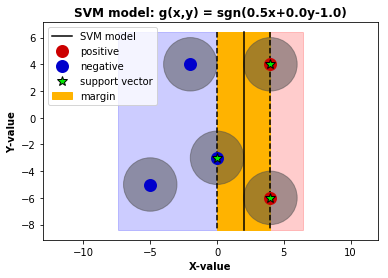

In [62]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

# SVM model class will be created here. Contains e.g. fit-function, kernel.     
class SVM:

    def __init__(self, kernel, C):
        self.kernel = kernel
        self.penalty_term = C
        
    def getKernel(self):
        return self.kernel
    
    def getPenaltyTerm(self):
        return self.penalty_term
    
    def checkActiveConstraints(self, alpha, d, M):
        # Check the constraints
        active_set_indexes = []
        #print("now a: ", alpha)
        #print("now d: ", d)
        for i in range(0, alpha.shape[0]):
            if (alpha[i] == 0 and d[i] < 0) or (alpha[i] == self.penalty_term and d[i] > 0):
                active_set_indexes.append(i)
        # If true, we need to update M
        
        #print("d = " + str(d))
        #print("alpha = " + str(alpha))
        if len(active_set_indexes) > 0:
            for i in range(0, len(active_set_indexes)):
                active_constraint = np.zeros((1, alpha.shape[0]))
                active_constraint[0, active_set_indexes[i]] = 1
                M = np.vstack([active_constraint, M])
            #print(M)
            return (M, active_set_indexes)
        else:
            return None
        
        print(M)
    
    def checkActiveConstraints2(self, alpha, d, M, g, I):
        # Check the constraints
        active_set_indexes = []
        needCon = True
        #print("???????????????")
        #print("M initial: \n" + str(M))
        for k in range(0, alpha.shape[0]):
                if np.abs(alpha[k]) < np.finfo(float).eps*10:
                    alpha[k] = 0.0
                if np.abs(d[k]) < np.finfo(float).eps*10:
                    d[k] = 0.0
        while needCon:
            #print("alpha, d at first step comp")
            #print("alpha\n", alpha)
            #print("d\n", d)
            for i in range(0, alpha.shape[0]):
                if (alpha[i] == 0 and d[i] < 0) or (alpha[i] == self.penalty_term and d[i] > 0):
                    active_set_indexes.append(i)
            # If true, we need to update M
            if len(active_set_indexes) > 0:
                for i in range(0, len(active_set_indexes)):
                    active_constraint = np.zeros((1, alpha.shape[0]))
                    active_constraint[0, active_set_indexes[i]] = 1
                    M = np.vstack([active_constraint, M])
            # M has been updated, check that some other semiactive constrains are not broken
            #print("M: \n" + str(M))
            Mt = M.transpose()
            #print("M:\n", M)
            #print("Mt:\n", Mt)
            #print("MMt\n", np.matmul(M, Mt))
            #print(np.matmul(M, Mt))
            #print("EPS", np.finfo(float).eps)
            MMt_1 = np.linalg.inv(np.matmul(M, Mt))
            P = I - np.matmul(Mt, np.matmul(MMt_1, M))
            d = np.matmul(-P, g(alpha))
            for k in range(0, alpha.shape[0]):
                if np.abs(d[k]) < np.finfo(float).eps*10:
                    d[k] = 0.0
            #print("d:", d)
            # Final check 
            #print("FINAL CHECK")
            #print(alpha,d)
            for i in range(0, alpha.shape[0]):
                #print("comparison", i, alpha[i], d[i], alpha[i]==0, alpha[i] == 0 and d[i] < 0)
                if (alpha[i] == 0 and d[i] < 0) or (alpha[i] == self.penalty_term and d[i] > 0):
                    needCon = True
                    active_set_indexes = []
                    break
                else:
                    needCon = False
        #print("M final: \n" + str(M))
        #print("ALTERNATIVE d: \n" + str(d))
        #print("alpha: \n" + str(alpha))
        #print("ALTERNATIVE constraints: \n" + str(active_set_indexes))
        #print("???????????????")
        return(d, active_set_indexes)

            
    
    def train(self, data, labels, epsilon, maxIters, **kwargs):
        
        iters = 1
        alpha = self.generateRandomAlpha(labels)
        #alpha = np.random.rand(data.shape[0], 1)
        #alpha[0] = 0.5
        #alpha[1] = 0.5
        #alpha[2] = 1.0
        #alpha[3] = 0.0
        alpha = np.zeros((data.shape[0], 1))
        Q_D = self.getKernelMatrix(data, labels, **kwargs)
        #print("kernel matrix Q_D = \n" + str(Q_D))
        g = lambda alpha : np.matmul(Q_D, alpha) - np.ones([alpha.shape[0],1])
        f = lambda alpha : 0.5*np.matmul(alpha.transpose(), np.matmul(Q_D, alpha)) - np.sum(alpha)
        I = np.identity(np.max(labels.shape))
        active_set_indexes = []
        while True:
            #print("kernel matrix Q_D = " + str(Q_D))
            #print("Q_D:", Q_D, "alpha", alpha)
            #print(g(alpha))
            #print(labels)
            # Initial projection matrix, only hyperplane constraint in beginning    
            M = labels
            Mt = M.transpose()
            MMt_1 = np.linalg.inv(np.matmul(M, Mt))
            P = I - np.matmul(Mt, np.matmul(MMt_1, M))
            #print(I, P)
            #print("P:\n" + str(np.matmul(P, I)))
            #print("PP:\n" + str(np.matmul(P,P)))
            #np.linalg.cholesky(P)
            d = np.matmul(-P, g(alpha))
            #print("P = " + str(P))
            #print("Current alpha: \n" + str(alpha))
            #print("Gradient g(alpha): \n" + str(g(alpha)))
            #print("Constraint matrix M: \n" + str(M))
            #print("Initial projection matrix P: \n" + str(P))
            #print("Initial search direction d: \n" + str(d))
            Mn_and_constraints = self.checkActiveConstraints(alpha, d, M)
            d_c = self.checkActiveConstraints2(alpha, d, M, g, I)
            #Mn = Mn_and_constraints[0]
            #active_set_indexes = Mn_and_constraints[1]
            #Mn, active_set_indexes = self.checkActiveConstraints(alpha, d, M)
            vari = None
            active_set_indexes = []
            if Mn_and_constraints is not None and vari is not None:
                #print("ACTIVE CONSTRAINTS")
                #print(Mn_and_constraints)
                M = Mn_and_constraints[0]
                Mt = M.transpose()
                MMt_1 = np.linalg.inv(np.matmul(M, Mt))
                P = I - np.matmul(Mt, np.matmul(MMt_1, M))
                d = np.matmul(-P, g(alpha))
                active_set_indexes = Mn_and_constraints[1]
                #print("Active indexes: " + str(active_set_indexes))
                #print("Updated constraint matrix M: \n" + str(M))
                #print("Updated projection matrix P: \n"+str(P))
                #print("Updated search direction d is = " + str(d))
            if vari is None:
                d = d_c[0]
                active_set_indexes = d_c[1]
                
            
            non_active_indexes = [x for x in range(0,np.max(labels.shape)) if x not in active_set_indexes]
            if kwargs["printInfo"]:
                print("Non-active set indexes:\n" + str(non_active_indexes))
                print("Corresponding non-active alpha-values: \n" + str(alpha[non_active_indexes]))
                print("Corresponding non-active d-values: \n" + str(d[non_active_indexes]))
                print("-alpha/d:\n" + str(-np.divide(alpha[non_active_indexes], d[non_active_indexes])))
                print("C-alpha/d:\n" + str(np.divide(self.penalty_term-alpha[non_active_indexes], d[non_active_indexes])))
                print([l for l in -np.divide(alpha[non_active_indexes], d[non_active_indexes]) if l > 0])
            lambda_0 = np.inf
            lambda_C = np.inf
            list_a0 = [l for l in -np.divide(alpha[non_active_indexes], d[non_active_indexes]) if l > 0]
            list_aC = [l for l in np.divide(self.penalty_term-alpha[non_active_indexes], d[non_active_indexes]) if l > 0]
            if len(list_a0) > 0:
                lambda_0 = np.min(list_a0)
            if len(list_aC) > 0:
                lambda_C = np.min(list_aC)
            
            lamlims = [lambda_0, lambda_C]
            #print("unedited lambdalims: " + str(lamlims) )
            lamlims = [l for l in lamlims if l > 0] 
            #np.linalg.cholesky(P)
            gPQ_DPg = np.matmul(g(alpha).transpose(), np.matmul(np.matmul(P, np.matmul(Q_D, P)), g(alpha)))
            gPg = np.matmul(g(alpha).transpose(), np.matmul(P, g(alpha)))
            #print("gPg = \n" + str(gPg))
            #print("gPQ_DPg = \n" +str(gPQ_DPg))
            lambda_d = gPg / float(gPQ_DPg)
            lambda_d = lambda_d[0][0]
            #print([lambda_0, lambda_C, lambda_d])
            lamlims.append(lambda_d)
            opt_lambda = np.max([0.0, np.min(lamlims)])
            if kwargs["printInfo"]:
                print("lambda limits: " + str(lamlims))
                print("lambda_d: " + str(lambda_d))
                print("Optimal step size: " + str(opt_lambda))
                print("Final search direction: \n" + str(d))
            old_alpha = alpha[:]
            alpha = alpha + opt_lambda*d
            
            #print("d="+str(d))
            #print("old_alpha =\n"+str(old_alpha))
            if kwargs["printInfo"]:
                print("alpha = "+str(alpha.transpose())) 
                print("Difference: " + str(np.sum(np.abs(alpha-old_alpha))))
                print("Function value: " + str(f(alpha)))
                print("hyperplane value: " + str(np.matmul(labels, alpha)))
                print("Iteration: " + str(iters))
                print("*****************************************************")
            for k in range(0, alpha.shape[0]):
                if np.abs(alpha[k]) < np.finfo(float).eps:
                    alpha[k] = 0.0
            if any(x<0 for x in alpha) == True:
                sys.exit('Negative entry in alpha!')
            if np.sum(np.abs(alpha-old_alpha)) < epsilon or iters == maxIters:
                break
            iters += 1
        return self.getSvmParameters(alpha, data, labels)
    
    
    
    def getSvmParameters(self, alpha, data, labels):
        print(alpha)
        data_length = np.max(labels.shape)
        w = np.zeros([1, data.shape[1]])
        non_zero_alphas_inds = []
        for i in range(0, data_length):
            #print(labels[0,i], alpha[i,0], data[i,:])
            w += labels[0,i]*alpha[i,0]*data[i]
            if alpha[i] > 0:
                non_zero_alphas_inds.append(i)
        nonz_alpha_y = labels[0,non_zero_alphas_inds[0]] # Assuming at least one exists
        nonz_alpha_x = data[non_zero_alphas_inds[0], :] # Assuming at least one exists
        b = 1/float(nonz_alpha_y)
        for i in range(0, data_length):
            b -= labels[0,i]*alpha[i,0]*np.dot(data[i,:], nonz_alpha_x)
        return(w[0], b, alpha)
        
    def createRandData(self, xdim, number_of_pos, number_of_neg, inter):
        dataX = np.array([1,2])
        dataY = []
        # Create a random line
        n_vector = np.random.rand(xdim, 1)
        bias = np.random.rand(1)
        bias = 0
        posfound = 0
        negfound = 0
        #print(dataX)
        while posfound < number_of_pos:
            #datap = np.random.rand(2)
            datap= np.random.randint(inter[0],inter[1], (1,2))
            #print(np.matmul(datap,n_vector))
            if np.matmul(datap,n_vector) > -bias: 
                dataX = np.vstack((dataX, datap))
                dataY.append(1)
                posfound += 1
        while negfound < number_of_neg:
            #datap = np.random.rand(2)
            datap= np.random.randint(inter[0],inter[1], (1,2))
            #print(np.matmul(datap,n_vector))
            np.matmul(datap,n_vector)
            if np.matmul(datap,n_vector) < -bias: 
                dataX = np.vstack((dataX, datap))
                dataY.append(-1)
                negfound += 1
        dataX = np.delete(dataX, 0, 0)
        #print(dataX, dataY)
        return(dataX, dataY)
    
    #######################################
    # 
    # DESCRIPTION: 
    # - Function used for generating the
    # kernel function Q_D. Three options: 
    # 'linear', 'Gaussian', 'polynomial'.
    # -------------------------------------
    # INPUT: numpy array of feature data,
    # numpy array of labels -1/+1,
    # additional parameters kwargs
    # -------------------------------------
    # OUTPUT: kernel matrix Q_D.
    #######################################
    def getKernelMatrix(self, data, labels, **kwargs):
        Q_D = np.zeros([np.size(labels), np.size(labels)])
        kernel_function = None
        if kwargs["printInfo"]:
            print("Using " + self.kernel + " kernel")
        if self.kernel == "linear":
            kernel_function = lambda x, y : np.dot(x,y)
        elif self.kernel == "Gaussian":
            kernel_function = lambda x, y : np.exp(-np.dot(x-y,x-y)/(2*kwargs["sigma"]**2))
        elif self.kernel == "polynomial":
            kernel_function = lambda x, y : (kwargs["lambda"] + kwargs["gamma"]*np.dot(x,y))**kwargs["q"]
        #print(kwargs["g"])
        for i in range(0, np.size(labels)):
            for j in range(0, np.size(labels)):
                Q_D[i,j] = labels[0,i]*labels[0,j]*kernel_function(data[i,:], data[j,:])
        return Q_D            
    
    #######################################
    # 
    # DESCRIPTION: 
    # - Function used for generating a
    # random feasible alpha solution a, 
    # that is yTa = 0, a >= 0.
    # -------------------------------------
    # INPUT: numpy array of labels -1/+1
    # -------------------------------------
    # OUTPUT: a feasible alpha solution of
    # numpy array type.
    # -------------------------------------
    # ASSUMPTIONS: There must exist at
    # least one +1 and -1 label.
    #######################################
    def generateRandomAlpha(self, labels):
        data_length = np.size(labels)
        alpha = np.zeros([data_length,1])
        p_inds = np.where(labels > 0)[1]
        n_inds = np.where(labels < 0)[1]
        # Check that we have at least one +1/-1 pair
        if np.size(p_inds) == 0 or np.size(n_inds) == 0:
            sys.exit('There must be at least one +1 and -1 data point!')
        # Generate random constraint satisfying alpha values for negative cases
        if self.penalty_term < np.inf:
            alpha[n_inds,0] = np.random.rand(np.size(n_inds))*self.penalty_term
        else: 
            alpha[n_inds,0] = np.random.rand(np.size(n_inds))
        negSum = np.sum(alpha)
        # The next step is just to make sure that penalty term constraint will be satisfied
        if negSum > self.penalty_term:
            alpha = np.true_divide(alpha, negSum/float(self.penalty_term))
            negSum = np.sum(alpha)
        # Next we generate the semirandom alpha values for positive labels
        pos_range = np.sort(np.random.rand(np.size(p_inds))*negSum)
        for i,val in enumerate(p_inds):
            if i == 0 and np.size(p_inds) == 1:
                alpha[val] = negSum
            elif i == 0: # First entry
                alpha[val] = pos_range[i]
            elif i == np.size(p_inds)-1: # Last entry
                alpha[val] = negSum-pos_range[i-1]
            else:
                alpha[val] = pos_range[i]-pos_range[i-1]
        # Final check, are constrains satisfied? 
        if (np.size(np.where(alpha > self.penalty_term)) != 0) or (np.abs(np.sum(alpha[p_inds,0])-np.sum(alpha[n_inds,0])) > np.finfo(float).eps):
            sys.exit('Initial aplha does not satisfy constraints!')
        return alpha
    
    
    
    
    # CODE FOR VISUALIZATION 
    
    def plot2D(self, data, labels, model,f=None,ax=None):
        w = model[0] # List entry containing the weights
        b = model[1] # List entry containing the bias
        alpha = model[2]
        wnorm = float(np.linalg.norm(w))
        margin = 1/wnorm # Margin of the SVM model
        # Next, we create the boundaries for the plot.
        minX = np.min(data[:,0])
        maxX = np.max(data[:,0])
        minY = np.min(data[:,1])
        maxY = np.max(data[:,1])  
        if f is None and ax is None:
            f,ax = plt.subplots(1)

        # Next, we draw the classification areas. We need to check the borders
        marginCoefficient = 1.2
        xborder = [minX-margin*marginCoefficient, maxX + margin*marginCoefficient]
        yborder = [minY-margin*marginCoefficient, maxY + margin*marginCoefficient]
        lineYvaluesAtXborder = [(-b-w[0]*xborder[0])/float(w[1]), (-b-w[0]*xborder[1])/float(w[1])]
        lineXvaluesAtYborder = [(-b-w[1]*yborder[0])/float(w[0]), (-b-w[1]*yborder[1])/float(w[0])]
        
        
        drawVals = self.getLineAndFillAreas(xborder, yborder, lineXvaluesAtYborder, lineYvaluesAtXborder)
        xvalues = drawVals[0]
        yvalues = drawVals[1]
        xFillArea1 = drawVals[2]
        yFillArea1 = drawVals[3]
        xFillArea2 = drawVals[4]
        yFillArea2 = drawVals[5]
        

        xPos, yPos = [], []
        xNeg, yNeg = [], []
        if xFillArea1[-1]*w[0] + yFillArea1[-1]*w[1] > -b:
            xPos = xFillArea1
            yPos = yFillArea1
            xNeg = xFillArea2
            yNeg = yFillArea2
        else:
            xPos = xFillArea2
            yPos = yFillArea2
            xNeg = xFillArea1
            yNeg = yFillArea1
        #print(xvalues, yvalues)
        ax.plot(xvalues, yvalues, 'k-', label="SVM model") 
        
        ba = margin*(w/wnorm)
        xval1, yval1 = [xvalues+ba[0]], [yvalues+ba[1]]
        xval2, yval2 = [xvalues-ba[0]], [yvalues-ba[1]]
        yv1 = self.getLineYvaluesAtXborder(xval1[0], yval1[0], xborder)
        xv1 = self.getLineXvaluesAtYborder(xval1[0], yval1[0], yborder)
        yv2 = self.getLineYvaluesAtXborder(xval2[0], yval2[0], xborder)
        xv2 = self.getLineXvaluesAtYborder(xval2[0], yval2[0], yborder)
        #print("top", xv1, yv1, "\n Down", xv2, yv2)
        
        drawVals1 = self.getLineAndFillAreas(xborder, yborder, xv1, yv1)
        xvalues1 = drawVals1[0]
        yvalues1 = drawVals1[1]
        
        drawVals2 = self.getLineAndFillAreas(xborder, yborder, xv2, yv2)
        xvalues2 = drawVals2[0]
        yvalues2 = drawVals2[1]
        
        ax.plot(xvalues1, yvalues1, 'k--') 
        ax.plot(xvalues2, yvalues2, 'k--') 

      
        ax.fill(xPos, yPos, color = [1, 0, 0], alpha=0.2)
        ax.fill(xNeg, yNeg, color = [0, 0, 1], alpha=0.2)
        marginVals = self.getMarginArea(xvalues1, yvalues1, xvalues2, yvalues2, xborder, yborder)
        ax.fill(marginVals[0], marginVals[1], color = [1, .7, 0], alpha=1, label="margin")
        
        
        markerSizeCircle = 10
        markerSizeCross = 10
        p1 = None;
        p2 = None;
        firstP = True
        firstN = True
        # Plot all the data points. 
        for i in range(0, data.shape[0]):
            if labels[0,i] > 0:
                if firstP:
                    ax.plot(data[i,0], data[i,1], "o", color=[.8, 0, 0], markersize=markerSizeCircle, markeredgewidth=3, label="positive")
                    firstP = False
                else:
                    ax.plot(data[i,0], data[i,1], "o", color=[.8, 0, 0], markersize=markerSizeCircle, markeredgewidth=3)
            else:
                if firstN:
                    ax.plot(data[i,0], data[i,1], "o", color=[0, 0, .8], markersize=markerSizeCross, markeredgewidth=3, label="negative")
                    firstN = False
                else:
                    ax.plot(data[i,0], data[i,1], "o", color=[0, 0, .8], markersize=markerSizeCross, markeredgewidth=3)

            circle1 = plt.Circle((data[i,0], data[i,1]), margin, color=[.3,.3,.3], clip_on=False, alpha=0.5)
            ax.add_patch(circle1)
            
        sv_inds = np.where(alpha > 0)[0]
        #print(sv_inds)
        ax.plot(data[sv_inds,0], data[sv_inds,1], "*", color=[0,.9,0], markersize=markerSizeCircle+1, markeredgewidth=1, markeredgecolor=[0,0,0], label="support vector")
        
        
        ax.axis('equal')
        #plt.rcParams['axes.xmargin'] = 0
        #f.tight_layout()
        #plt.margins(x=0,y=0, tight=True)
        #f.subplots_adjust(bottom=0, top=1, left=0, right=1)
        #ax.get_xaxis().set_visible(False)
        #ax.get_yaxis().set_visible(False)
        #f.tight_layout()

        str2 = None
        str3 = None

        if w[1] < 0:
            str2 = str(np.round(w[1],4))
        else:
            str2 = "+" + str(np.round(w[1],4))
        if b < 0:
            str3 = str(np.round(b,4))
        else:
            str3 = "+" + str(np.round(b,4))
            
        ax.set_title("SVM model: g(x,y) = sgn(" + str(np.round(w[0],4)) + "x" + str2 + "y" + str3 + ")", fontweight='bold')
        ax.set_xlabel("X-value", fontweight='bold')
        ax.set_ylabel("Y-value", fontweight='bold')
        
        ax.legend()
        #plt.show() 
        #plt.title("SVM model: g(x,y) = sgn(" + str(np.round(w[0],4)) + "x" + str2 + "y" + str3 + ")", fontweight='bold')
        #plt.xlabel("X-value", fontweight='bold')
        #plt.ylabel("Y-value", fontweight='bold')
        
        #plt.legend()
        if f is None and ax is None:
            plt.show() 
        
    def getMarginArea(self, xv1, yv1, xv2, yv2, xborder, yborder):
        marginAreaX = []
        marginAreaY = []
        if (yv1[0]==yv2[0] and yv1[1]==yv2[1]) or (xv1[0]==xv2[0] and xv1[1]==xv2[1]): # Cases 1 and 2
            #print("Margin case 1 or 2")
            marginAreaX = [xv1[0], xv1[1], xv2[1], xv2[0]] 
            marginAreaY = [yv1[0], yv1[1], yv2[1], yv2[0]] 
        elif yv1[0]==yv2[0] and yv1[0] > yv1[1]: # Slope negative, case 3
            #print("Margin case 3")
            marginAreaX = [xv1[0], xv1[1], xborder[1], xv2[1], xv2[0]] 
            marginAreaY = [yv1[0], yv1[1], yborder[0], yv2[1], yv2[0]]
        elif yv1[0]==yv2[0] and yv1[0] < yv1[1]: # positive, case 4
            #print("Margin case 4")
            marginAreaX = [xv1[0], xv1[1], xborder[1], xv2[1], xv2[0]] 
            marginAreaY = [yv1[0], yv1[1], yborder[1], yv2[1], yv2[0]]
        elif yv1[1]==yv2[1] and yv1[0] < yv1[1]: # positive, case 5, left corner down
            #print("Margin case 5")
            marginAreaX = [xv1[0], xv1[1], xv2[1], xv2[0], xborder[0]] 
            marginAreaY = [yv1[0], yv1[1], yv2[1], yv2[0], yborder[0]]
        elif yv1[1]==yv2[1] and yv1[0] > yv1[1]: # negative, case 6, left corner up
            #print("Margin case 6")
            marginAreaX = [xv1[0], xv1[1], xv2[1], xv2[0], xborder[0]] 
            marginAreaY = [yv1[0], yv1[1], yv2[1], yv2[0], yborder[1]]
        elif xv1[1]==xv2[1] and yv1[0] > yv1[1]: # negative, case 7, left corner up
            #print("Margin case 7")
            marginAreaX = [xv1[0], xv1[1], xv2[1], xv2[0], xborder[0]] 
            marginAreaY = [yv1[0], yv1[1], yv2[1], yv2[0], yborder[1]]
        elif xv1[1]==xv2[1] and yv1[0] < yv1[1]: # negative, case 8, left corner up
            #print("Margin case 8")
            marginAreaX = [xv1[0], xv1[1], xv2[1], xv2[0], xborder[0]] 
            marginAreaY = [yv1[0], yv1[1], yv2[1], yv2[0], yborder[0]]
        elif xv1[0]==xv2[0] and yv1[0] < yv1[1]: # negative, case 8, left corner up
            #print("Margin case 9")
            marginAreaX = [xv1[0], xv1[1], xborder[1], xv2[1], xv2[0]] 
            marginAreaY = [yv1[0], yv1[1], yborder[1], yv2[1], yv2[0]]
        elif xv1[0]==xv2[0] and yv1[0] > yv1[1]: # negative, case 8, left corner up
            #print("Margin case 10")
            marginAreaX = [xv1[0], xv1[1], xborder[1], xv2[1], xv2[0]] 
            marginAreaY = [yv1[0], yv1[1], yborder[0], yv2[1], yv2[0]]
        elif yv1[0] < yv1[1]: #positive slope, case 8, left corner up
            #print("Margin case 11")
            marginAreaX = [xv1[0], xv1[1], xborder[1], xv2[1], xv2[0], xborder[0]] 
            marginAreaY = [yv1[0], yv1[1], yborder[1], yv2[1], yv2[0], yborder[0]]
        elif yv1[0] > yv1[1]: #positive slope, case 8, left corner up
            #print("Margin case 12")
            marginAreaX = [xv1[0], xv1[1], xborder[1], xv2[1], xv2[0], xborder[0]] 
            marginAreaY = [yv1[0], yv1[1], yborder[0], yv2[1], yv2[0], yborder[1]]
        return(marginAreaX, marginAreaY)

     
        
    def getLineXvaluesAtYborder(self, xvals, yvals, yborder):
        slope = (yvals[1]-yvals[0]) / (xvals[1]-xvals[0])
        bias = yvals[0]-slope*xvals[0]
        x = lambda y: (y-bias)/float(slope)
        return [x(yborder[0]), x(yborder[1])]
    
    def getLineYvaluesAtXborder(self, xvals, yvals, xborder):
        slope = (yvals[1]-yvals[0]) / (xvals[1]-xvals[0])
        bias = yvals[0]-slope*xvals[0]
        y = lambda x: slope*x + bias
        return [y(xborder[0]), y(xborder[1])]

        
        
    def getLineAndFillAreas(self, xborder, yborder, lineXvaluesAtYborder, lineYvaluesAtXborder):
        xFillArea1 = []
        yFillArea1 = []
        xFillArea2 = []
        yFillArea2 = []
        xvalues = []
        yvalues = []
        if np.min(lineYvaluesAtXborder) < yborder[0] and np.max(lineYvaluesAtXborder) > yborder[1]: # Cases where y goes over border, does not touch x-border
            minXind = np.where(lineXvaluesAtYborder==np.min(lineXvaluesAtYborder))[0][0]
            maxXind = [i for i in [0, 1] if i not in [minXind]][0]
            xvalues = [lineXvaluesAtYborder[minXind], lineXvaluesAtYborder[maxXind]]
            yvalues = [yborder[minXind], yborder[maxXind]]
            xFillArea1, yFillArea1 = xvalues[:], yvalues[:]
            xFillArea2, yFillArea2 = xvalues[:], yvalues[:]
            if yvalues[1] > yvalues[0]: # Positive slope
                #print("CASE 1")
                xFillArea1.extend([xborder[0], xborder[0]])
                xFillArea2.extend([xborder[1], xborder[1]])
                yFillArea1.extend([yborder[1], yborder[0]])
                yFillArea2.extend([yborder[1], yborder[0]])
            else: # Negative slope
                #print("CASE 2")
                xFillArea1.extend([xborder[0], xborder[0]])
                xFillArea2.extend([xborder[1], xborder[1]])
                yFillArea1.extend([yborder[0], yborder[1]])
                yFillArea2.extend([yborder[0], yborder[1]])
        elif np.min(lineYvaluesAtXborder) > yborder[0] and np.max(lineYvaluesAtXborder) < yborder[1]: # Y inside border, cases 3,4
            xvalues = xborder[:]
            yvalues = lineYvaluesAtXborder[:]
            xFillArea1, yFillArea1 = xvalues[:], yvalues[:]
            xFillArea2, yFillArea2 = xvalues[:], yvalues[:]
            if yvalues[1] > yvalues[0]: # Positive slope
                #print("CASE 3")
                xFillArea1.extend([xborder[1], xborder[0]])
                xFillArea2.extend([xborder[1], xborder[0]])
                yFillArea1.extend([yborder[1], yborder[1]])
                yFillArea2.extend([yborder[0], yborder[0]])
            else: # Negative slope
                #print("CASE 4")
                xFillArea1.extend([xborder[1], xborder[0]])
                xFillArea2.extend([xborder[1], xborder[0]])
                yFillArea1.extend([yborder[1], yborder[1]])
                yFillArea2.extend([yborder[0], yborder[0]])
        elif (lineYvaluesAtXborder[0] > yborder[0] and lineYvaluesAtXborder[0] < yborder[1]) and lineYvaluesAtXborder[1] > yborder[1] : # Y inside border, cases 3,4
            xvalues = [xborder[0], lineXvaluesAtYborder[1]]
            yvalues = [lineYvaluesAtXborder[0], yborder[1]]
            xFillArea1, yFillArea1 = xvalues[:], yvalues[:]
            xFillArea2, yFillArea2 = xvalues[:], yvalues[:]
            #print("CASE 5")
            xFillArea1.extend([xborder[0]])
            xFillArea2.extend([xborder[1], xborder[1], xborder[0]])
            yFillArea1.extend([yborder[1]])
            yFillArea2.extend([yborder[1], yborder[0], yborder[0]])
        elif (lineYvaluesAtXborder[0] > yborder[0] and lineYvaluesAtXborder[0] < yborder[1]) and lineYvaluesAtXborder[1] < yborder[0]: # Y inside border, cases 3,4 
            xvalues = [xborder[0], lineXvaluesAtYborder[0]]
            yvalues = [lineYvaluesAtXborder[0], yborder[0]]
            xFillArea1, yFillArea1 = xvalues[:], yvalues[:]
            xFillArea2, yFillArea2 = xvalues[:], yvalues[:]
            #print("CASE 6")
            xFillArea1.extend([xborder[1], xborder[1], xborder[0]])
            xFillArea2.extend([xborder[0]])
            yFillArea1.extend([yborder[0], yborder[1], yborder[1]])
            yFillArea2.extend([yborder[0]])
        elif lineYvaluesAtXborder[0] < yborder[0] and lineYvaluesAtXborder[1] < yborder[1] and lineYvaluesAtXborder[1] > yborder[0]:
            xvalues = [lineXvaluesAtYborder[0], xborder[1]]
            yvalues = [yborder[0], lineYvaluesAtXborder[1]]
            xFillArea1, yFillArea1 = xvalues[:], yvalues[:]
            xFillArea2, yFillArea2 = xvalues[:], yvalues[:]
            #print("CASE 7")
            xFillArea1.extend([xborder[1], xborder[0], xborder[0]])
            xFillArea2.extend([xborder[1]])
            yFillArea1.extend([yborder[1], yborder[1], yborder[0]])
            yFillArea2.extend([yborder[0]])
        elif lineYvaluesAtXborder[0] > yborder[1] and lineYvaluesAtXborder[1] < yborder[1] and lineYvaluesAtXborder[1] > yborder[0]:
            xvalues = [lineXvaluesAtYborder[1], xborder[1]]
            yvalues = [yborder[1], lineYvaluesAtXborder[1]]
            xFillArea1, yFillArea1 = xvalues[:], yvalues[:]
            xFillArea2, yFillArea2 = xvalues[:], yvalues[:]
            #print("CASE 8")
            xFillArea1.extend([xborder[1]])
            xFillArea2.extend([xborder[1], xborder[0], xborder[0]])
            yFillArea1.extend([yborder[1]])
            yFillArea2.extend([yborder[0], yborder[0], yborder[1]])
        return(xvalues, yvalues, xFillArea1, yFillArea1, xFillArea2, yFillArea2)
        
    def plotMaker(self, rows, cols):
        f, ax = plt.subplots(rows, cols, figsize=(20,10))
        ind = 0
        inter = [-17,7]
        mv = sys.float_info.min
        kwargs = {"sigma":1, "l":0, "g":1, "q":1, "printInfo":False}
        for r in range(0, rows):
            for c in range(0, cols):
                dataM = self.createRandData(2,2,2, inter)
                dataX=dataM[0]
                dataY=dataM[1]
                dataY = np.reshape(dataY, (1, len(dataY)))
                a = self.train(dataX, dataY, mv, 1000, **kwargs)
                if rows == 1 and cols == 1:
                    self.plot2D(dataX, dataY, a, f, ax)
                elif rows == 1:
                    self.plot2D(dataX, dataY, a, f, ax[c])
                elif cols == 1:
                    self.plot2D(dataX, dataY, a, f, ax[r])
                else:
                    self.plot2D(dataX, dataY, a, f, ax[r,c])
                ind += 1
        plt.show()
        
# DEMO EXAMPLE: Hard margin SVM

# Step 1: Create SVM object
SVM_model = SVM("linear", np.inf) # Create a SVM object with infinite penalty term
kwargs = {"sigma":1, "lambda":0, "gamma":1, "q":1, "printInfo":False}

# Step 2: Create random data set 
value_selection_interval = [-6,6]
number_of_positive_samples = 2
number_of_negative_samples = 3
X_feature_dimensions = 2
data_container = SVM_model.createRandData(X_feature_dimensions, number_of_positive_samples, number_of_negative_samples, value_selection_interval)
X_data = data_container[0]
Y_data = data_container[1]
#X_data = np.array([[0,1], [0,2], [1,1], [1,2]]) # TROUBLE CASE HERE!
#Y_data = [-1, -1, 1, 1]
Y_data = np.reshape(Y_data, (1, len(Y_data))) # Reshape data to fit format

# Step 3: Train the SVM
error_tolerance = np.finfo(float).eps
# error_tolerance = sys.float_info.min
iterations = 1000
model_parameters = SVM_model.train(X_data, Y_data, error_tolerance, iterations, **kwargs)



#SVM_model.plotMaker(1,3)
SVM_model.plot2D(X_data, Y_data, model_parameters)

# SOME ISSUES WITH MATRIX SINGULARITY, FLOATING POINT PRECISION I THINK...NEED TO MAKE EPS CHECK
 # ISSUE 1, CHECK PRBLEM CASE
# ISSUE 2, CHECK EPS LIMIT

In [ ]:
    # BACKUP CODE
    
    def generateRandomAlphaBackup(self, labels):
        negInds = []
        posInds = []
        data_length = np.max(labels.shape) # Assumes >= 4
        for i in range(0, data_length):
            if labels[0,i] < 0:
                negInds.append(i)
            elif labels[0,i] > 0:
                posInds.append(i)
        p1 = np.zeros([data_length,1])
        p2 = np.zeros([data_length,1])
        p1[posInds[0]] = 1
        p1[negInds[0]] = 1
        p2[posInds[1]] = 1
        p2[negInds[1]] = 1
        alpha = np.random.rand(1)[0]*p1 + np.random.rand(1)[0]*p2
        if self.penalty_term < np.inf: # Finite C, soft-margin
            alpha = np.random.rand(1)[0]*self.penalty_term*p1 + np.random.rand(1)[0]*self.penalty_term*p2
        #print(p1.transpose(), p2)
        #print("p1p2: \n" + str(np.matmul(p1.transpose(),p2)))
        #print("hp", np.matmul(labels, alpha))
        return alpha